Import Libraries

In [2]:
import csv
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from collections import Counter

Explore the data

In [3]:
path_to_data = "/Users/alicja/Desktop/PROJECT/Healthcare-Diabetes.csv"
df = pd.read_csv(path_to_data)

In [ ]:
df

In [ ]:
df.shape

In [ ]:
df.columns

In [ ]:
df.info()

In [ ]:
df.duplicated().sum()

In [ ]:
df.isnull().sum()

In [ ]:
df.describe().T

The minimum value in the columns should be greater than 0. I'm checking how many cells in a given column have a zero value.

Assumptions:
  "Id" - not needed for this evaluation,
  "Pregnancies" - 0 value is valid data,
  "Outcome" - 0 value is valid data (indicates no diabetes).

In [ ]:
data = df.drop(columns=["Id", "Pregnancies", "Outcome"])

num_of_zero_values_per_column = (data == 0).sum()
percentage = round(num_of_zero_values_per_column / len(df.index) * 100, 2)

result = pd.concat([num_of_zero_values_per_column, percentage], axis=1, keys=["Number of rows","Percentage of all rows"])
result.sort_values(by="Percentage of all rows")

Missing data (value 0) in the 'Glucose,' 'BMI,' and 'BloodPressure' columns make up a small percentage of the data. Therefore, depending on the data distribution, the value of zero will be changed to the mean (in the case of a normal distribution) or the median.

The same strategy has been applied to the 'SkinThickness' column. Despite the missing data percentage being 28.9%, losing such a large amount of data with a relatively small dataset would be unfavorable for further analysis.

The 'Insulin' column will be removed due to the fact that the missing data percentage is almost 50%.


Glucose	18	0.65
BMI	39	1.41
BloodPressure	125	4.52
SkinThickness	800	28.90
Insulin	1330	48.05

In [ ]:
for column in df.drop(columns=["Id", "Outcome"]):
    fig, axs = plt.subplots(1, 3, figsize=(20, 7))
    axs = axs.flatten()

    bins = 25
    if column == "Pregnancies" or "Age":
        bins = 12
   
    sns.histplot(df[df["Outcome"] == 0][column], bins=bins, color="#009966",  label="healthy", stat="density", ax=axs[0])
    sns.histplot(df[df["Outcome"] == 1][column], bins=bins, color="#E53B1A", label="diabetes", stat="density", ax=axs[0])
    
    sns.boxplot(df[df["Outcome"] == 0][column], color="#009966", ax=axs[1])
    sns.boxplot(df[df["Outcome"] == 1][column], color="#E53B1A", ax=axs[2])
    
    axs[1].set_title(column)
    axs[0].set_xlabel("")
    axs[0].set_ylabel("probability")
    #axs[1].set_ylabel("")
    axs[2].set_ylabel("")
    axs[0].legend()
    plt.tight_layout()
    plt.show()

In [4]:
def replace_missing_data_median(column_name):
    for i in range(2):
        median = df[df["Outcome"] == i][column_name][df[column_name] > 0].median()
        cell_to_replace = df[df["Outcome"] == i]["Id"][df[column_name] == 0]

        for id_num in cell_to_replace:
            df.loc[id_num-1, column_name] = median

In [5]:
def replace_missing_data_mean(column_name):
    for i in range(2):
        mean = df[df["Outcome"] == i][column_name][df[column_name] > 0].mean()
        cell_to_replace = df[df["Outcome"] == i]["Id"][df[column_name] == 0]

        for id_num in cell_to_replace:
            df.loc[id_num-1, column_name] = mean

In [6]:
for column in ["Glucose", "BMI", "SkinThickness"]:
    replace_missing_data_median(column)

replace_missing_data_mean("BloodPressure")

df = df.drop(columns="Insulin")

/var/folders/fv/xq0ksdjj6qs_gmxn6yvd1j7c0000gn/T/ipykernel_691/3479991247.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '70.85051546391753' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[id_num-1, column_name] = mean


In [ ]:
sns.pairplot(data=df, vars=df.columns[1:8], hue="Outcome", palette=["#3B86CB", "#F8C512"])
plt.tight_layout()

In [ ]:
correlation_matrix = df[df.columns[1:]].corr()

fig, ax = plt.subplots(figsize=(6, 6))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
cmap = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)

sns.heatmap(correlation_matrix, vmin=0, vmax=1, linewidth=0.5, cmap=cmap, square=True, 
            mask=mask, cbar_kws={"shrink": 0.55} )

In [ ]:
correlation_matrix.drop("Outcome")

In [ ]:
correlation_between_features = (correlation_matrix.where(np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1))
                                .stack()
                                .sort_values(ascending=False))

print(f"The top 10 highest correlation coefficients between individual features: \n\n{correlation_between_features.nlargest(10)}")

In [ ]:
plt.figure(figsize=(12, 8))
color = sns.color_palette("crest", 28)
color.reverse()
correlation_between_features.plot.barh(color=color, width=0.75).invert_yaxis()
plt.tight_layout()

In [ ]:
corr_with_outcome = correlation_matrix.drop("Outcome")["Outcome"].sort_values(ascending=False)
print(f"Correlation coefficient of individual features with the target: \n\n{corr_with_outcome}")

In [ ]:
plt.figure(figsize=(8, 3))
color = sns.color_palette('crest', 7)
color.reverse()
corr_with_outcome.plot.barh(color=color).invert_yaxis()
plt.tight_layout()

In [ ]:
outcome_count = df['Outcome'].value_counts()

outcome_count.plot(kind="pie",
                    title="Ratio of people without diabetes \n to people with diabetes",
                    labels=["healthy", "diabetes"], 
                    ylabel="",
                    colors=["#009966", "#E53B1A"], 
                    explode=[0, 0.1], 
                    shadow=True, 
                    autopct='%1.1f%%', 
                    radius=1, 
                    wedgeprops={"edgecolor": "black"})

plt.tight_layout()
plt.show()

Machine Learning - binary classification

Preparing data:
1) split dataset to train, validation and test set
2) scale dataset
3) oversample

In [7]:
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report

In [8]:
df = df.drop(columns="Id")
df

Pregnancies  Glucose  BloodPressure  SkinThickness   BMI  \
0               6      148           72.0             35  33.6   
1               1       85           66.0             29  26.6   
2               8      183           64.0             32  23.3   
3               1       89           66.0             23  28.1   
4               0      137           40.0             35  43.1   
...           ...      ...            ...            ...   ...   
2763            2       75           64.0             24  29.7   
2764            8      179           72.0             42  32.7   
2765            6       85           78.0             27  31.2   
2766            0      129          110.0             46  67.1   
2767            2       81           72.0             15  30.1   

      DiabetesPedigreeFunction  Age  Outcome  
0                        0.627   50        1  
1                        0.351   31        0  
2                        0.672   32        1  
3                        0.167   21        0  
4                        2.288   33        1  
...                        ...  ...      ...  
2763                     0.370   33        0  
2764                     0.719   36        1  
2765                     0.382   42        0  
2766                     0.319   26        1  
2767                     0.547   25        0  

[2768 rows x 8 columns]

Machine Learning - binary classification

Preparing data:
1) split dataset to train, validation and test set
2) scale dataset
3) oversample

In [9]:
train, valid, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

/usr/local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [10]:
def scale_dataset(dataframe, oversample=False):
    X = dataframe[dataframe.columns[:-1]].values
    y = dataframe[dataframe.columns[-1]].values

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    if oversample:
        ros = RandomOverSampler()
        X, y = ros.fit_resample(X, y)

    data = np.hstack((X, np.reshape(y, (-1, 1))))

    return data, X, y

In [11]:
train, X_train, y_train = scale_dataset(train, oversample=True)
valid, X_valid, y_valid = scale_dataset(valid, oversample=False)
test, X_test, y_test = scale_dataset(test, oversample=False)

kNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

In [ ]:
y_pred = knn_model.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))

Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

In [ ]:
y_pred = nb_model.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))

Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
# mona uyć inna wartość penalty
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

In [ ]:
y_pred = lr_model.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))

SVM

In [ ]:
from sklearn.svm import SVC

In [ ]:
svm_model = SVC()
svm_model.fit(X_train, y_train)

In [ ]:
y_pred = svm_model.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))

Neural Network

In [12]:
import tensorflow as tf

2023-10-25 11:46:03.225152: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [25]:
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
    ax1.plot(history.history['loss'], label="loss")
    ax1.plot(history.history['val_loss'], label="val_loss")
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('binary crossentropy')
    ax1.legend()
    ax1.grid(True)
   
    ax2.plot(history.history['accuracy'], label='accuracy')
    ax2.plot(history.history['val_accuracy'], label='val_accuracy')
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

In [26]:
def train_model(X_train, y_train, num_nodes, dropout_prob, lr, batch_size, epochs):
    nn_model = tf.keras.Sequential([
        tf.keras.layers.Dense(num_nodes, activation="relu", input_shape=(7,)),
        tf.keras.layers.Dropout(dropout_prob),
        tf.keras.layers.Dense(num_nodes, activation="relu"),
        tf.keras.layers.Dropout(dropout_prob),
        tf.keras.layers.Dense(1, activation="sigmoid")
        ])

    nn_model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss="binary_crossentropy", metrics=["accuracy"])

    history = nn_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                           validation_data=(X_valid, y_valid), verbose=0)

    return nn_model, history

16 nodes, dropout 0, lr 0.01, batch size 32


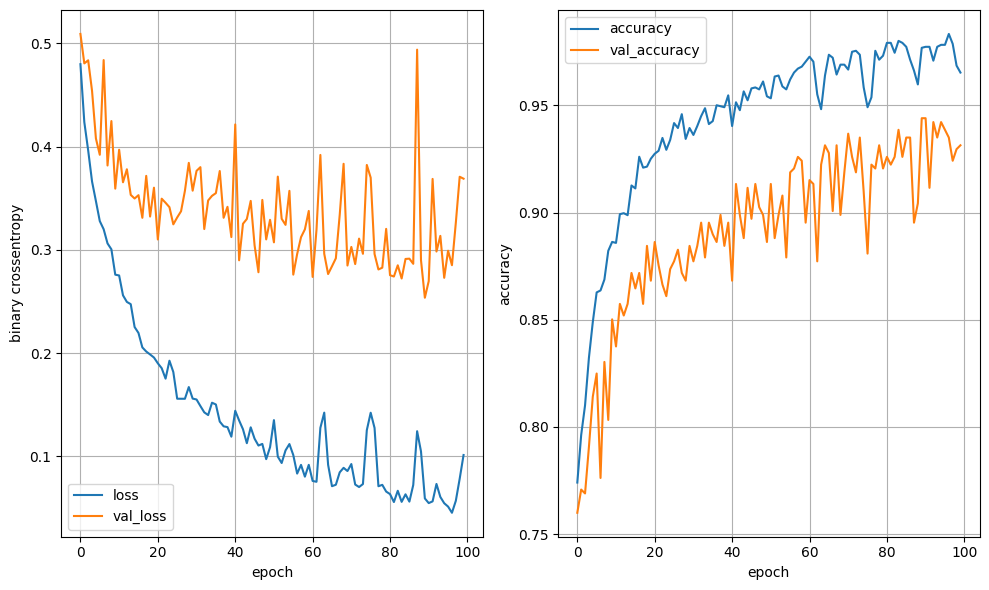

18/18 [==============================] - 0s 2ms/step - loss: 0.3690 - accuracy: 0.9314
16 nodes, dropout 0, lr 0.01, batch size 64


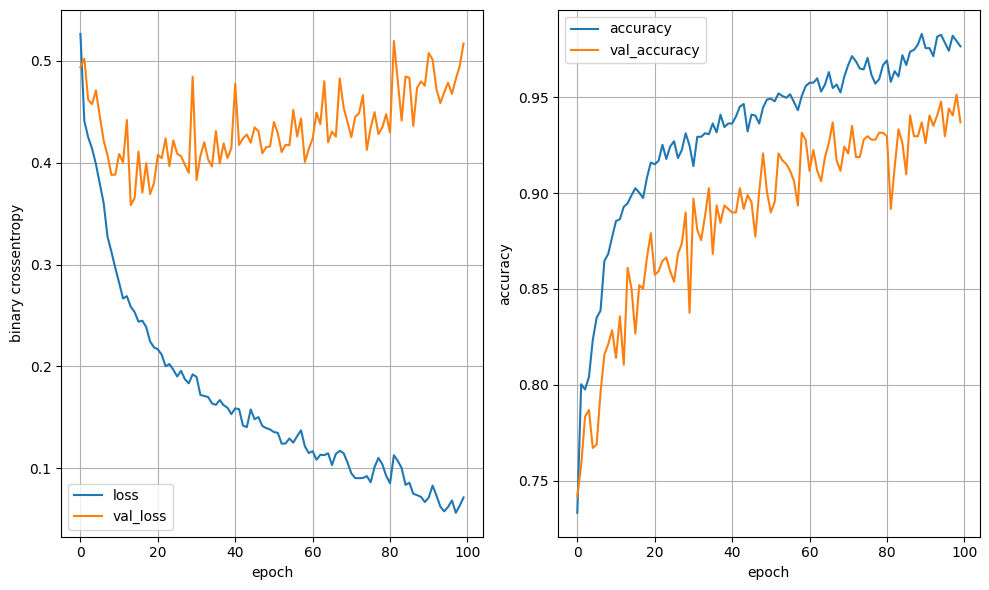

18/18 [==============================] - 0s 1ms/step - loss: 0.5172 - accuracy: 0.9368
16 nodes, dropout 0, lr 0.01, batch size 128


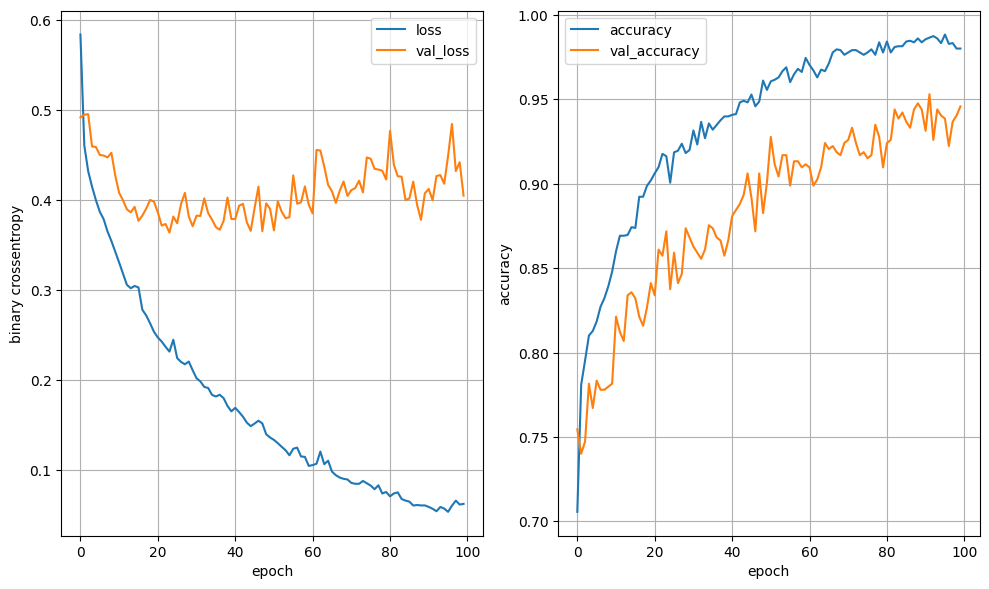

18/18 [==============================] - 0s 1ms/step - loss: 0.4048 - accuracy: 0.9458
16 nodes, dropout 0, lr 0.005, batch size 32


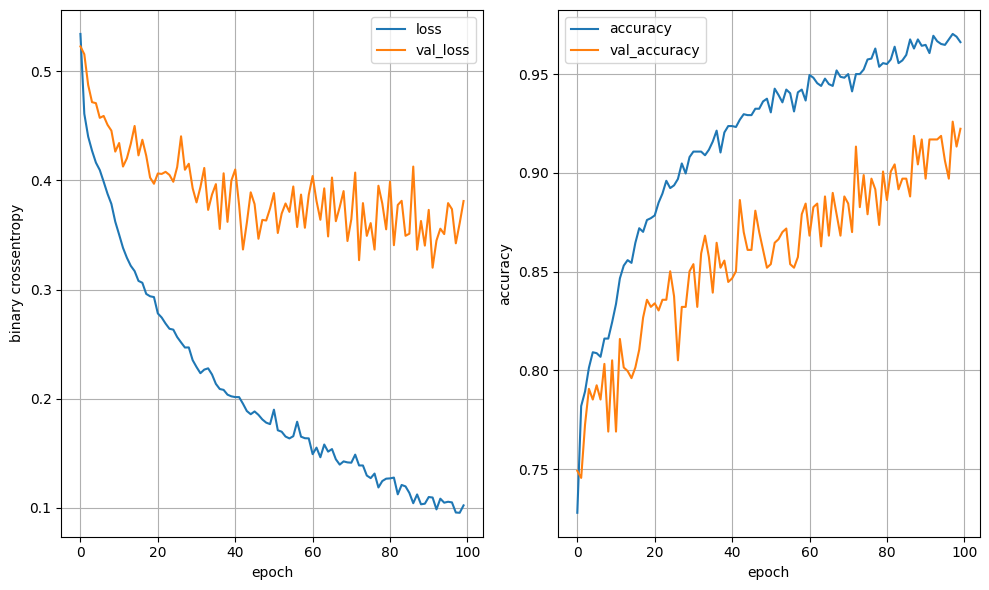

18/18 [==============================] - 0s 2ms/step - loss: 0.3811 - accuracy: 0.9224
16 nodes, dropout 0, lr 0.005, batch size 64


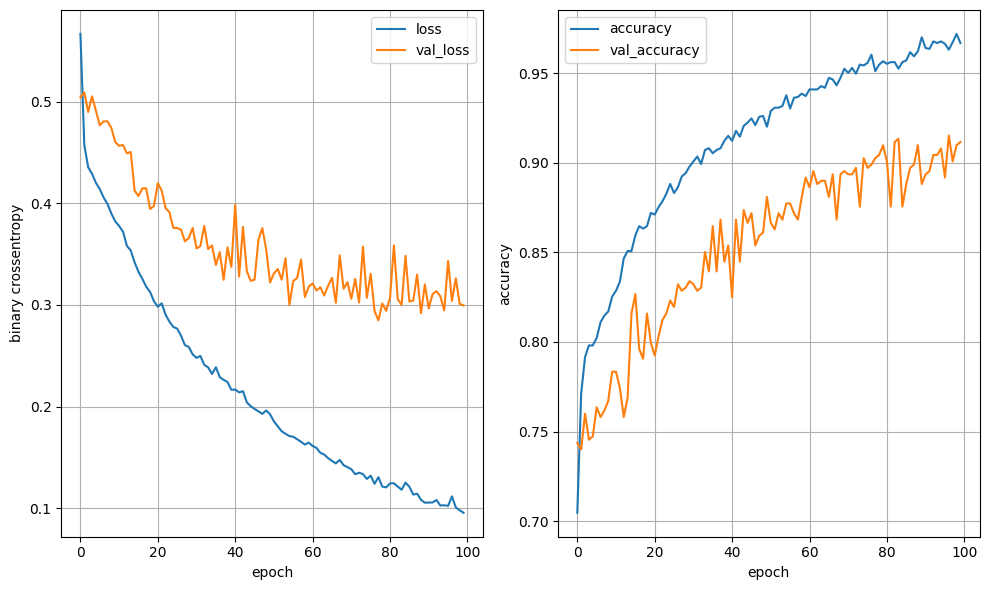

18/18 [==============================] - 0s 1ms/step - loss: 0.2996 - accuracy: 0.9116
16 nodes, dropout 0, lr 0.005, batch size 128


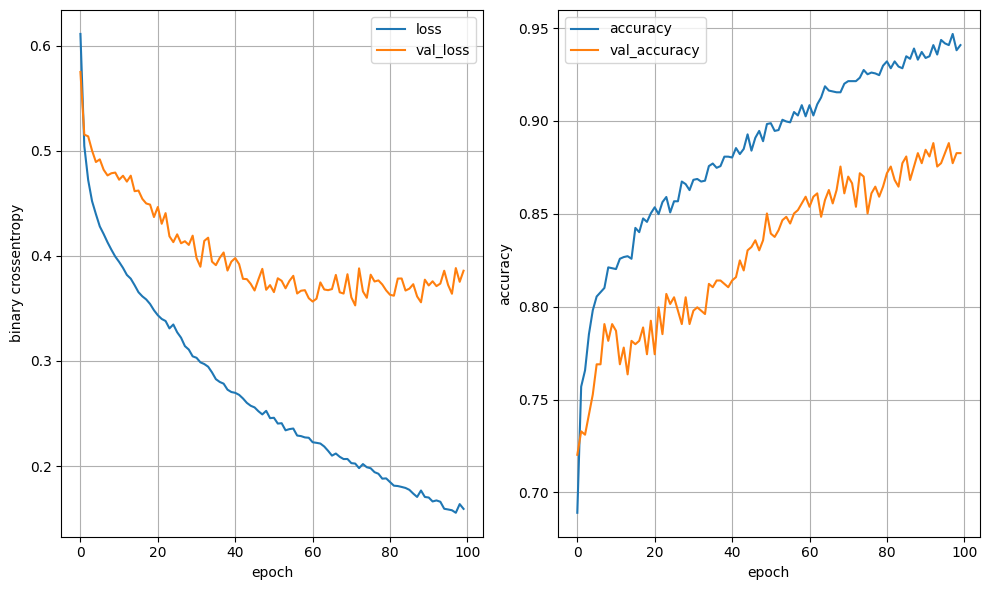

18/18 [==============================] - 0s 1ms/step - loss: 0.3858 - accuracy: 0.8827
16 nodes, dropout 0, lr 0.001, batch size 32


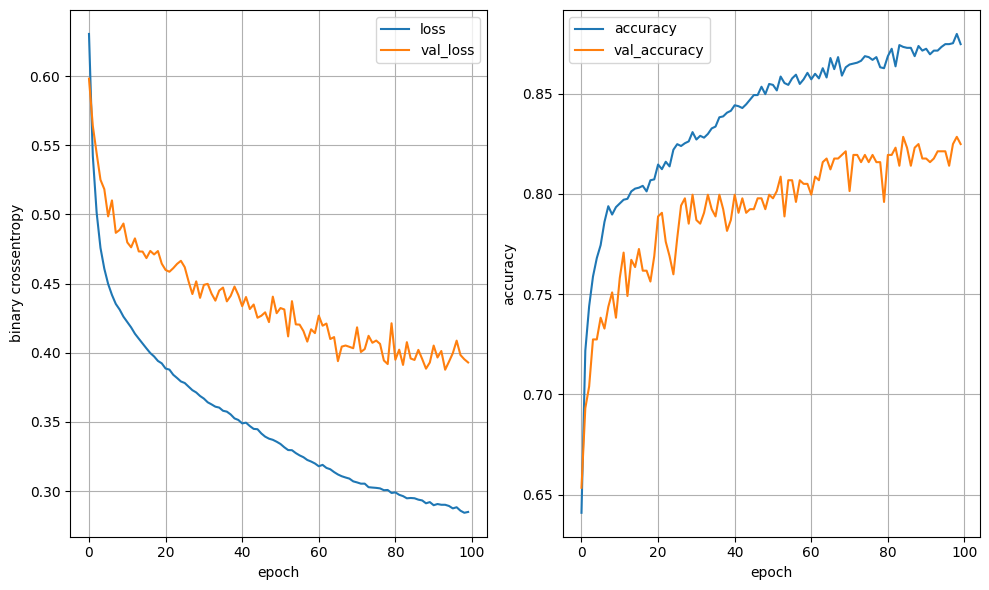

18/18 [==============================] - 0s 2ms/step - loss: 0.3930 - accuracy: 0.8249
16 nodes, dropout 0, lr 0.001, batch size 64


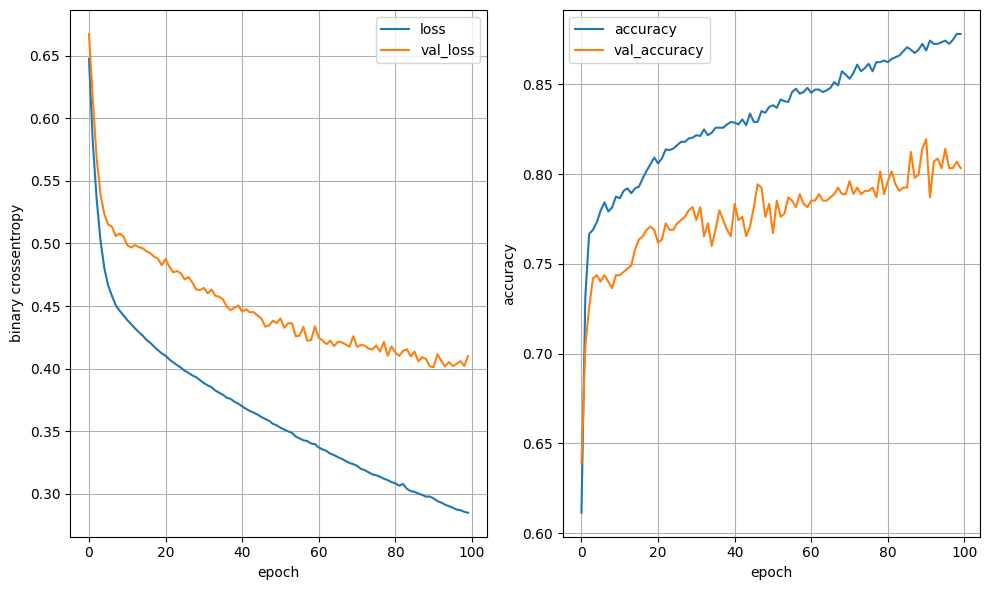

18/18 [==============================] - 0s 2ms/step - loss: 0.4102 - accuracy: 0.8032
16 nodes, dropout 0, lr 0.001, batch size 128


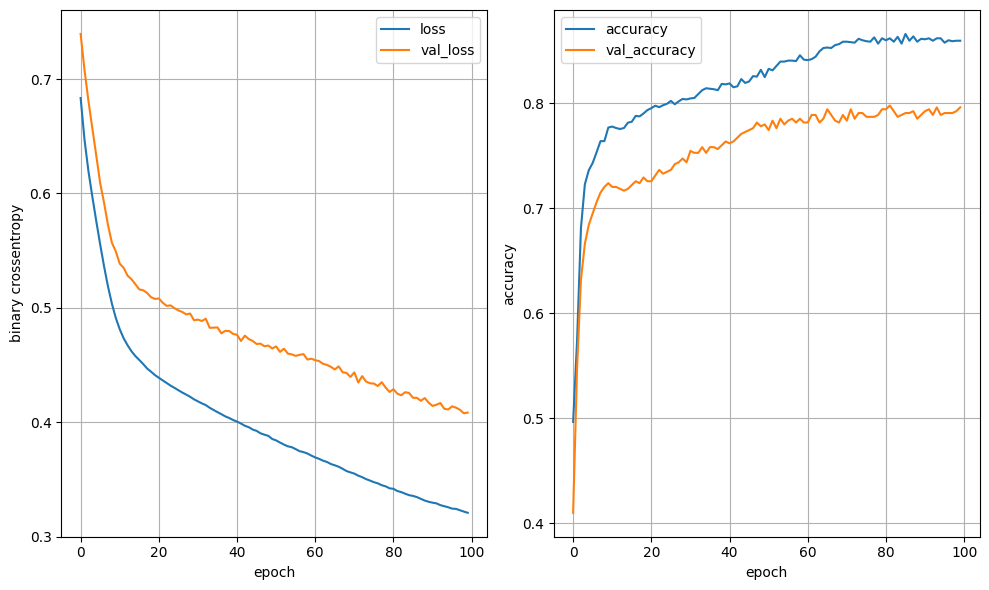

18/18 [==============================] - 0s 1ms/step - loss: 0.4084 - accuracy: 0.7960
16 nodes, dropout 0.2, lr 0.01, batch size 32


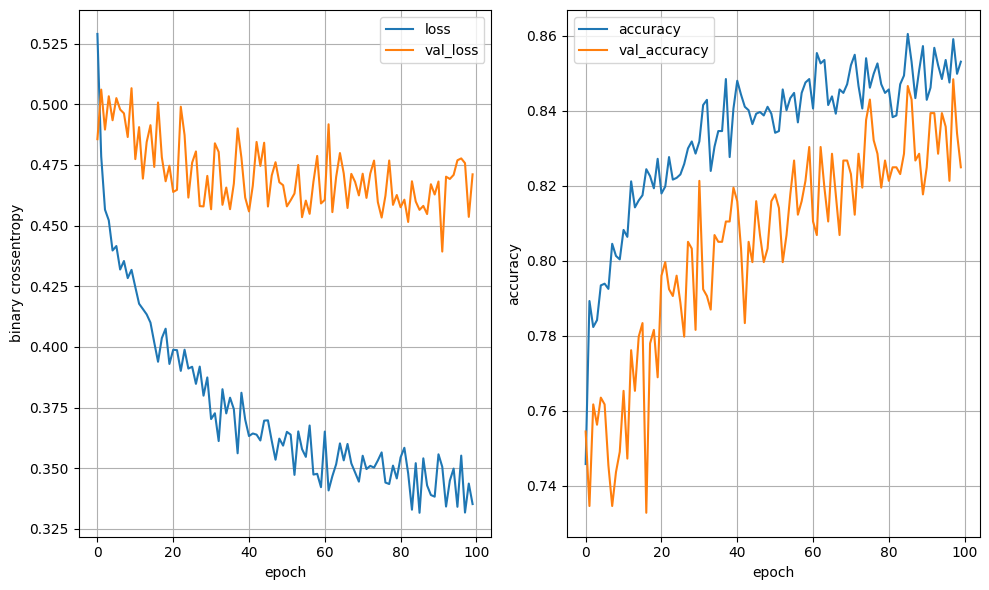

18/18 [==============================] - 0s 2ms/step - loss: 0.4711 - accuracy: 0.8249
16 nodes, dropout 0.2, lr 0.01, batch size 64


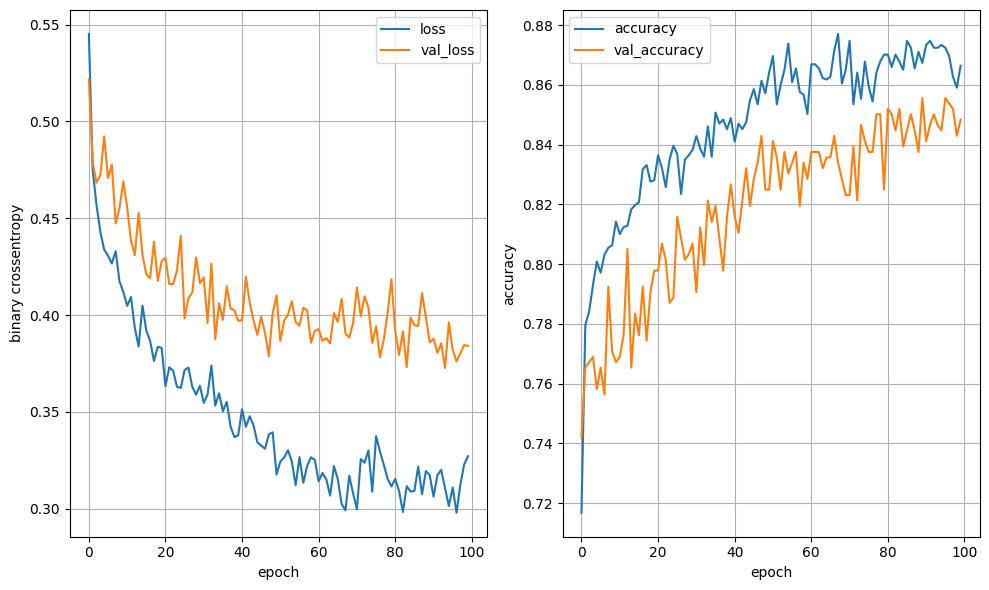

18/18 [==============================] - 0s 1ms/step - loss: 0.3841 - accuracy: 0.8484
16 nodes, dropout 0.2, lr 0.01, batch size 128


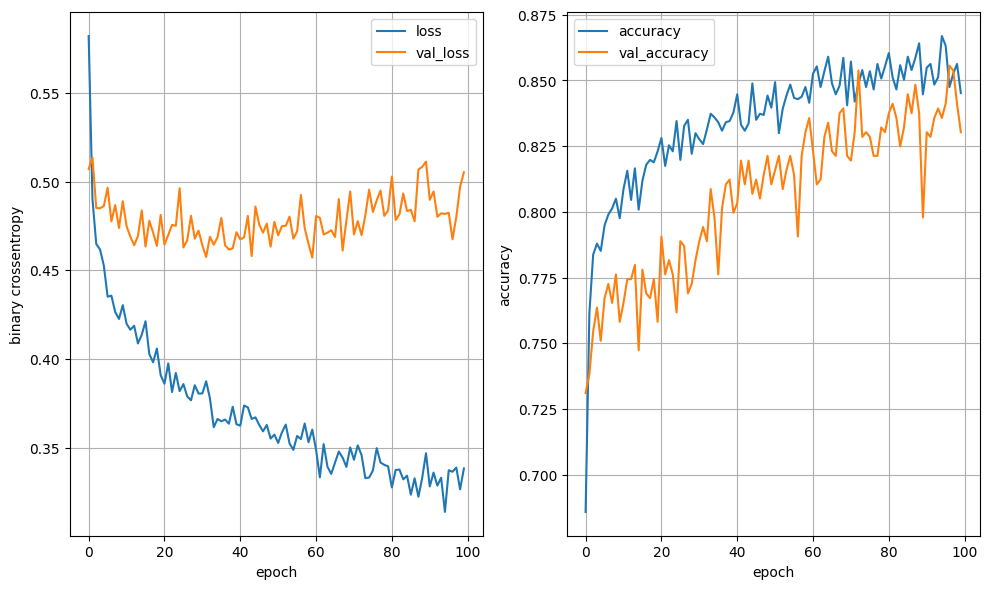

18/18 [==============================] - 0s 2ms/step - loss: 0.5052 - accuracy: 0.8303
16 nodes, dropout 0.2, lr 0.005, batch size 32


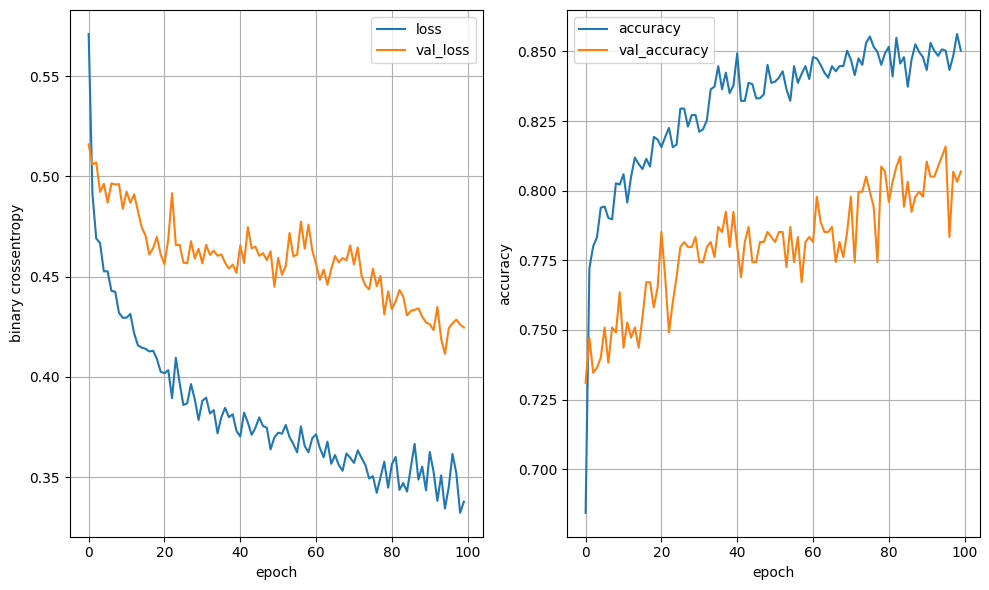

18/18 [==============================] - 0s 2ms/step - loss: 0.4246 - accuracy: 0.8069
16 nodes, dropout 0.2, lr 0.005, batch size 64


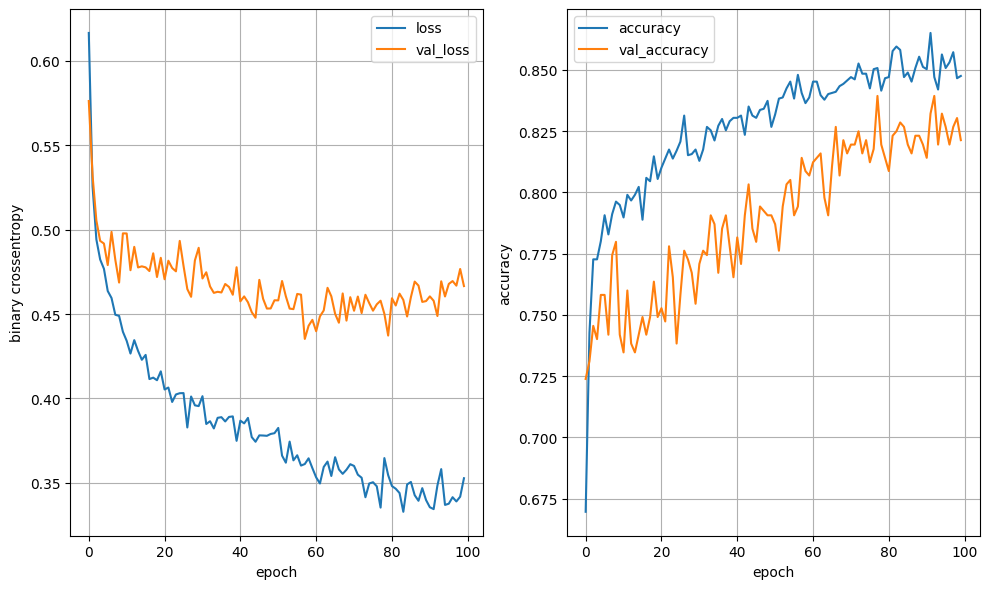

18/18 [==============================] - 0s 2ms/step - loss: 0.4666 - accuracy: 0.8213
16 nodes, dropout 0.2, lr 0.005, batch size 128


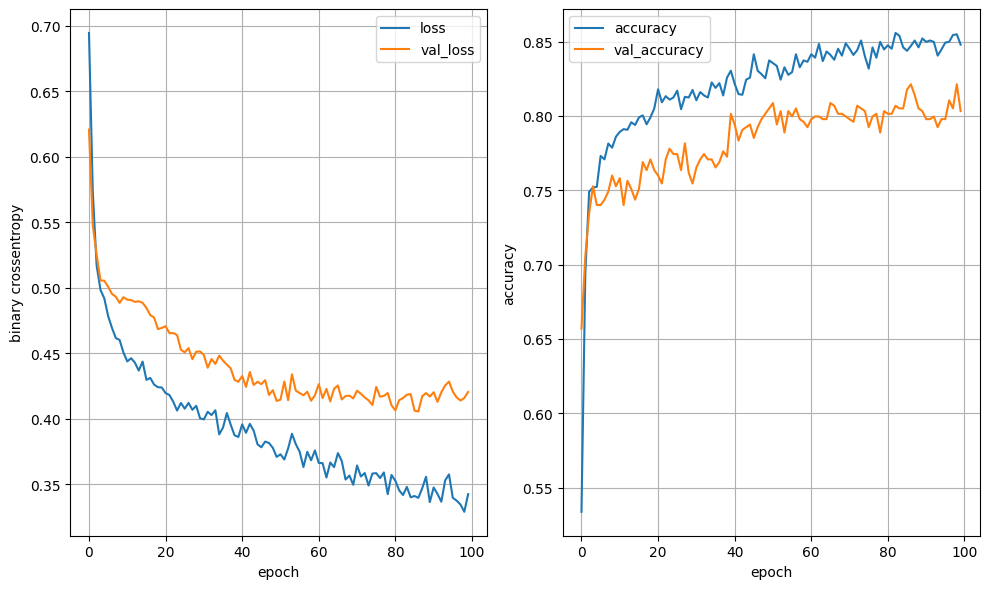

18/18 [==============================] - 0s 1ms/step - loss: 0.4206 - accuracy: 0.8032
16 nodes, dropout 0.2, lr 0.001, batch size 32


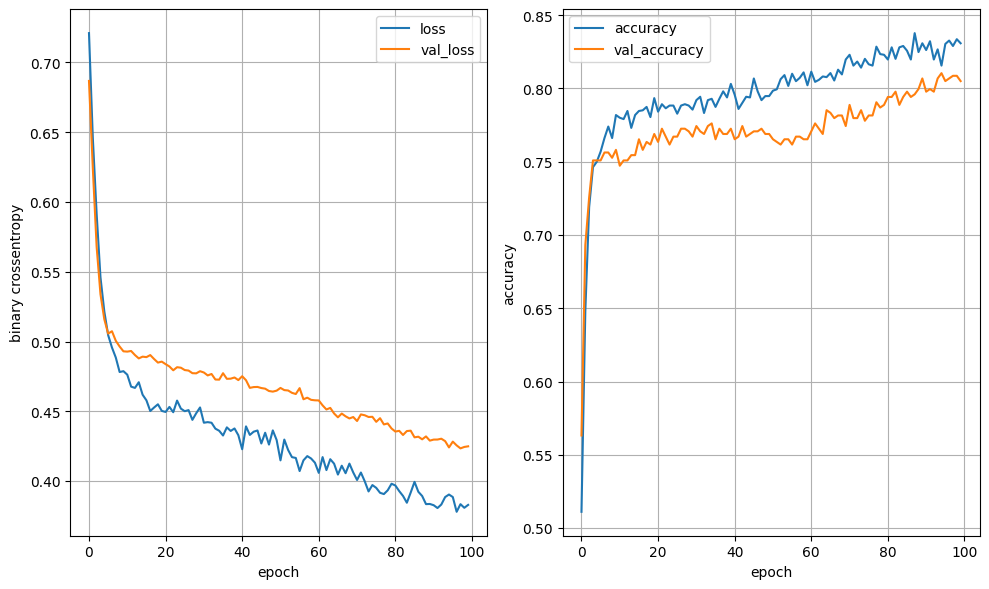

18/18 [==============================] - 0s 1ms/step - loss: 0.4249 - accuracy: 0.8051
16 nodes, dropout 0.2, lr 0.001, batch size 64


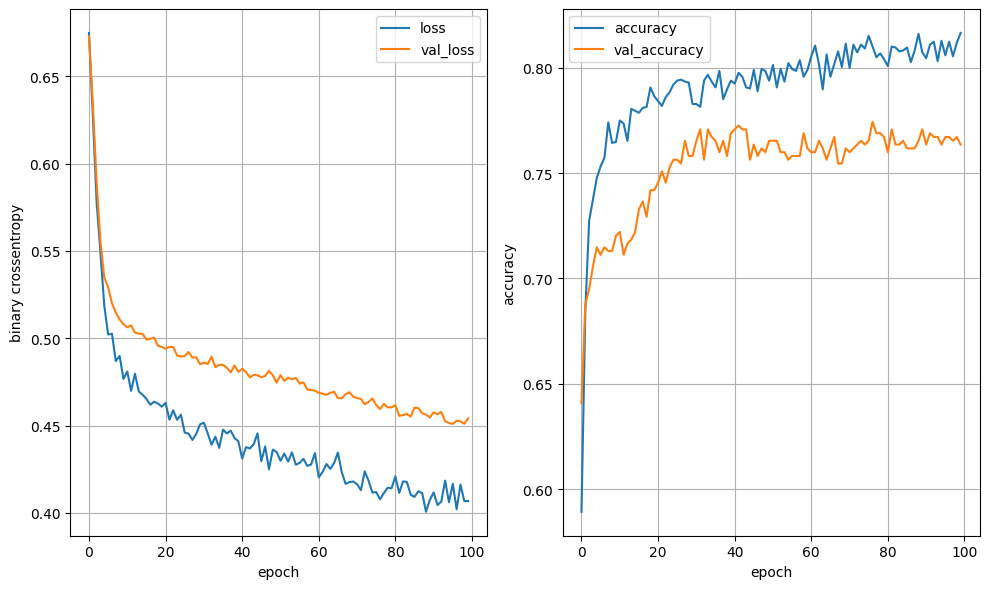

18/18 [==============================] - 0s 2ms/step - loss: 0.4542 - accuracy: 0.7635
16 nodes, dropout 0.2, lr 0.001, batch size 128


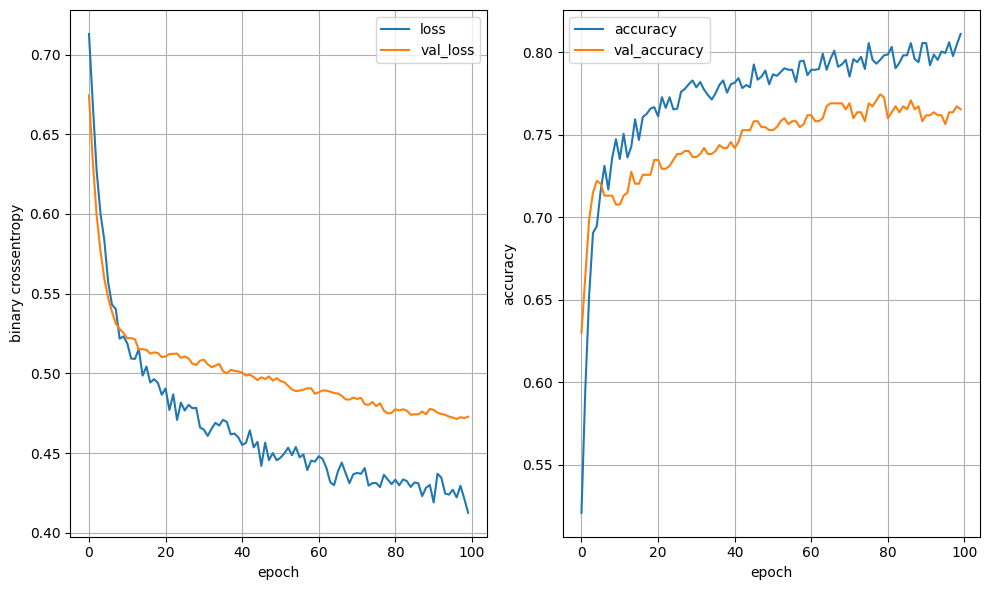

18/18 [==============================] - 0s 2ms/step - loss: 0.4728 - accuracy: 0.7653
32 nodes, dropout 0, lr 0.01, batch size 32


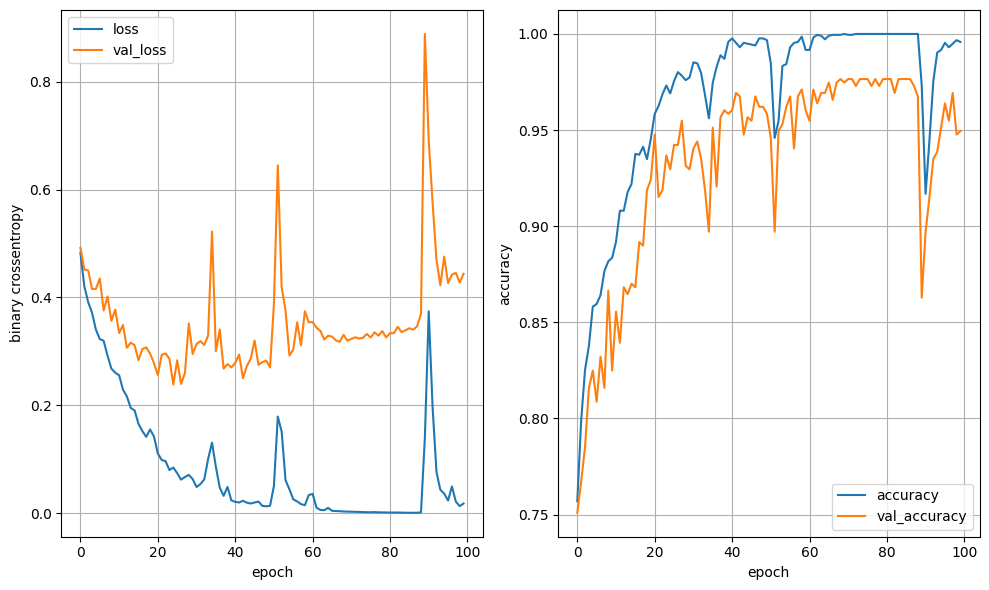

18/18 [==============================] - 0s 2ms/step - loss: 0.4440 - accuracy: 0.9495
32 nodes, dropout 0, lr 0.01, batch size 64


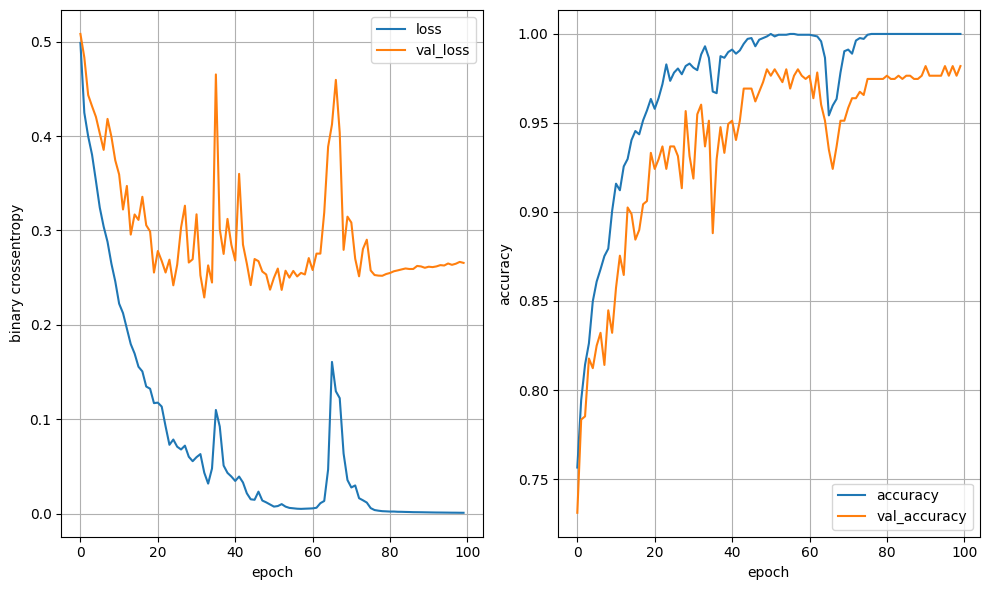

18/18 [==============================] - 0s 2ms/step - loss: 0.2657 - accuracy: 0.9819
32 nodes, dropout 0, lr 0.01, batch size 128


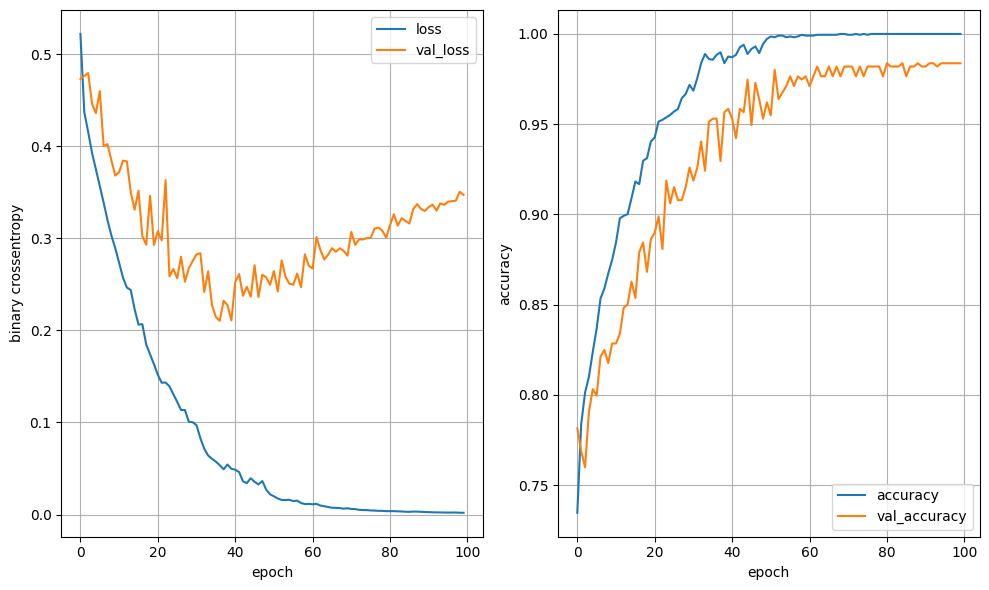

18/18 [==============================] - 0s 1ms/step - loss: 0.3472 - accuracy: 0.9838
32 nodes, dropout 0, lr 0.005, batch size 32


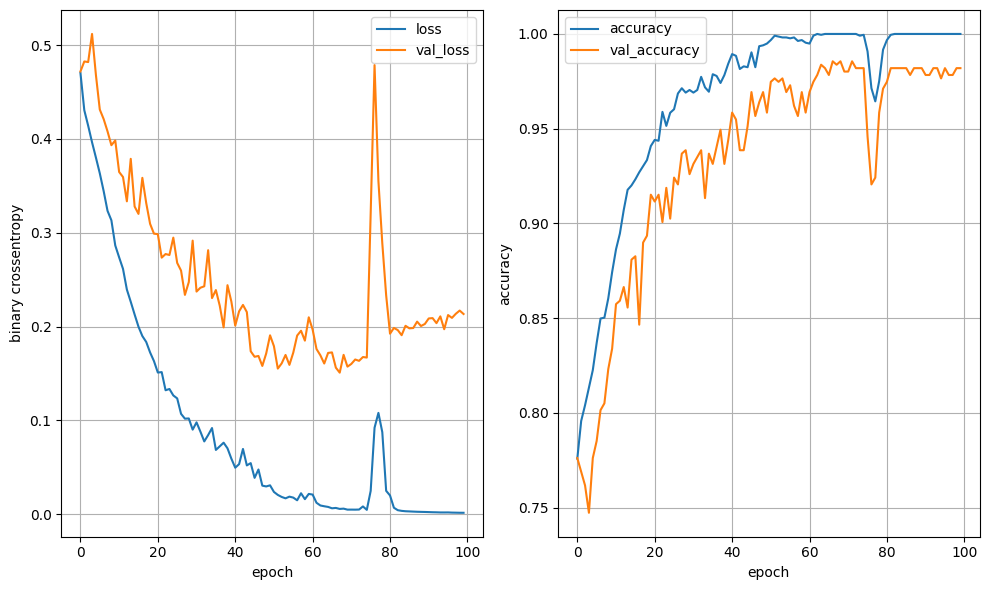

18/18 [==============================] - 0s 2ms/step - loss: 0.2134 - accuracy: 0.9819
32 nodes, dropout 0, lr 0.005, batch size 64


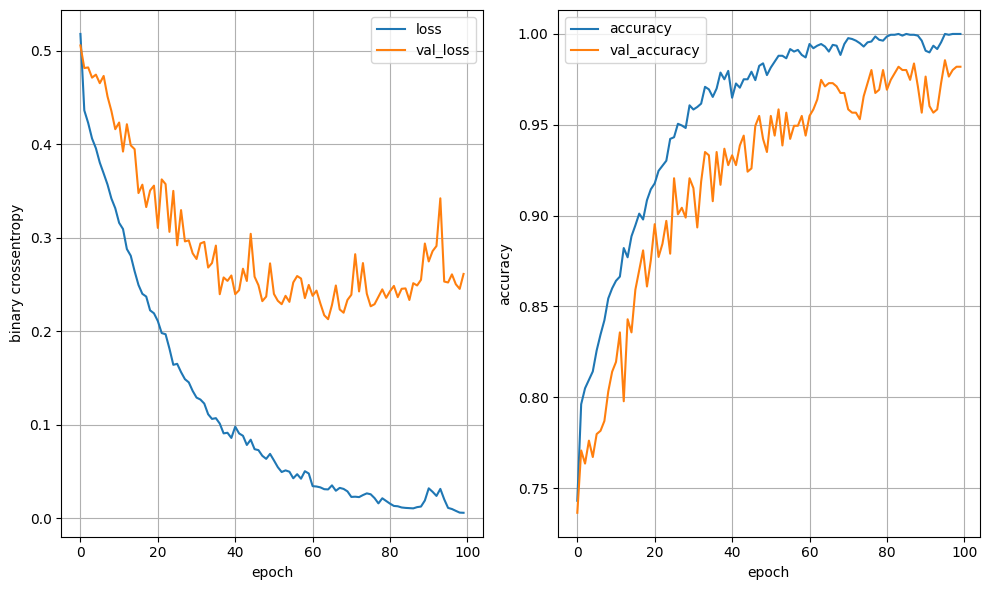

18/18 [==============================] - 0s 1ms/step - loss: 0.2613 - accuracy: 0.9819
32 nodes, dropout 0, lr 0.005, batch size 128


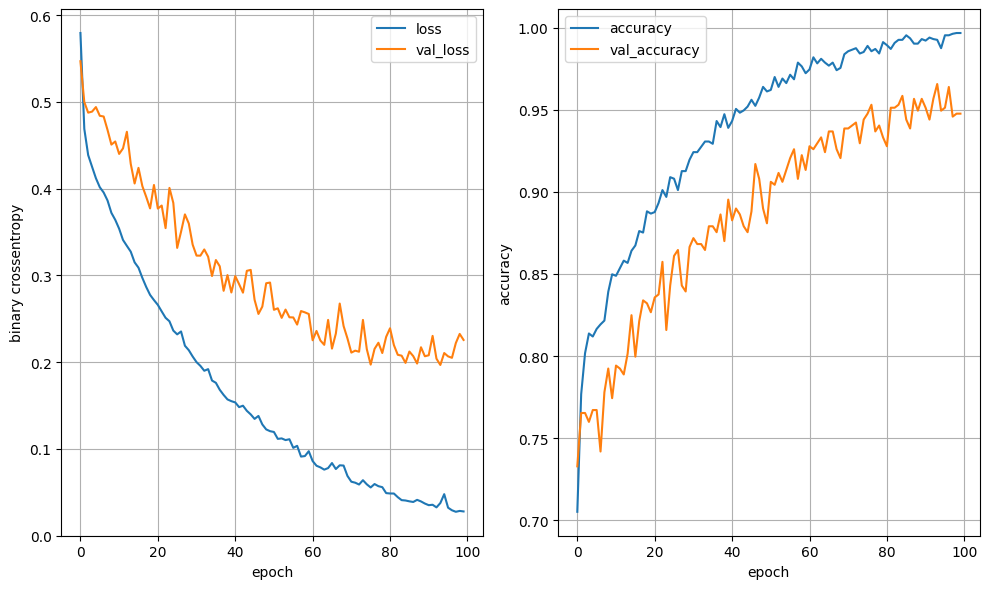

18/18 [==============================] - 0s 2ms/step - loss: 0.2256 - accuracy: 0.9477
32 nodes, dropout 0, lr 0.001, batch size 32


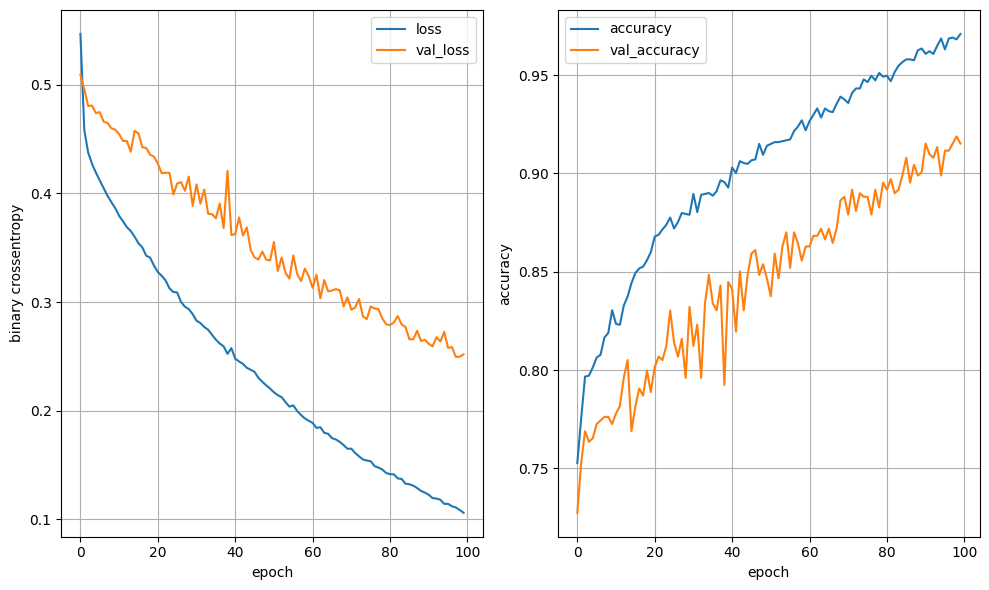

18/18 [==============================] - 0s 2ms/step - loss: 0.2518 - accuracy: 0.9152
32 nodes, dropout 0, lr 0.001, batch size 64


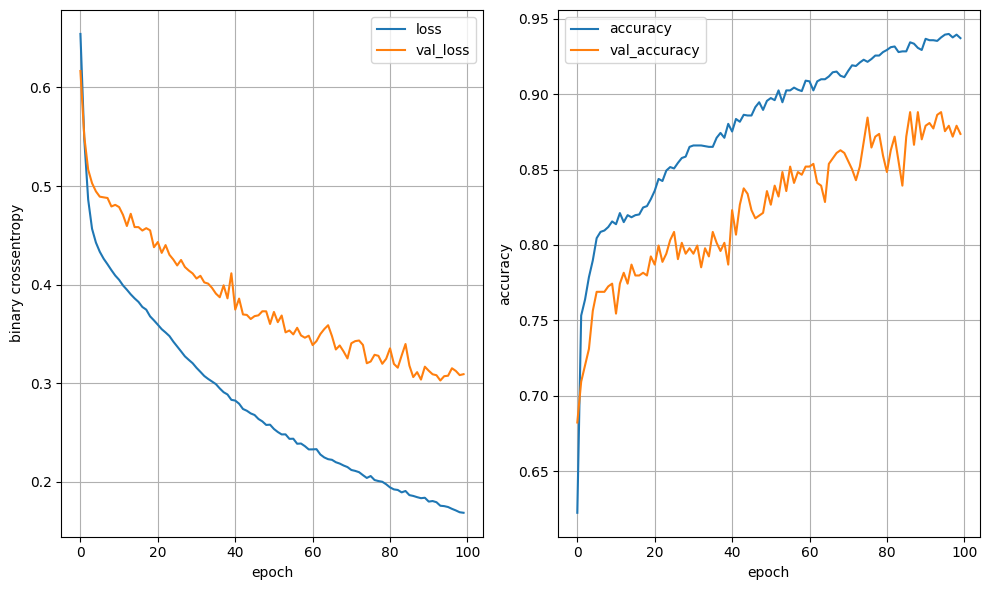

18/18 [==============================] - 0s 2ms/step - loss: 0.3092 - accuracy: 0.8736
32 nodes, dropout 0, lr 0.001, batch size 128


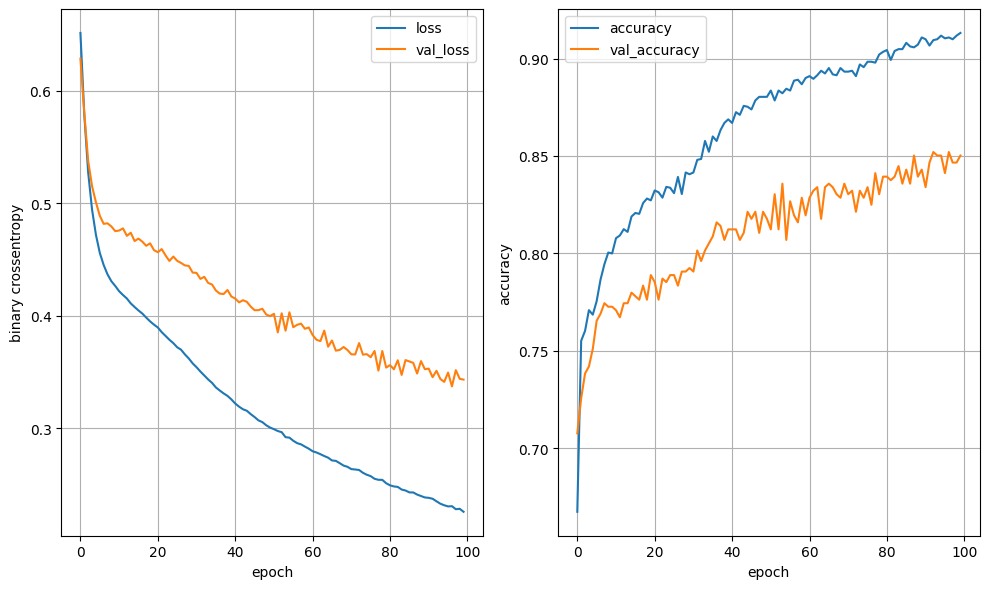

18/18 [==============================] - 0s 1ms/step - loss: 0.3434 - accuracy: 0.8502
32 nodes, dropout 0.2, lr 0.01, batch size 32


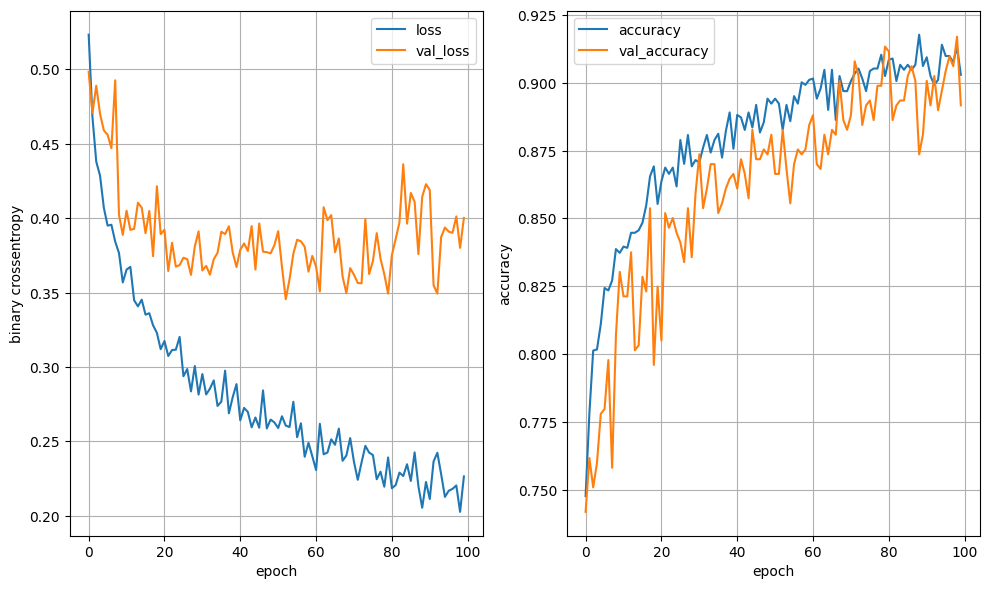

18/18 [==============================] - 0s 2ms/step - loss: 0.4001 - accuracy: 0.8917
32 nodes, dropout 0.2, lr 0.01, batch size 64


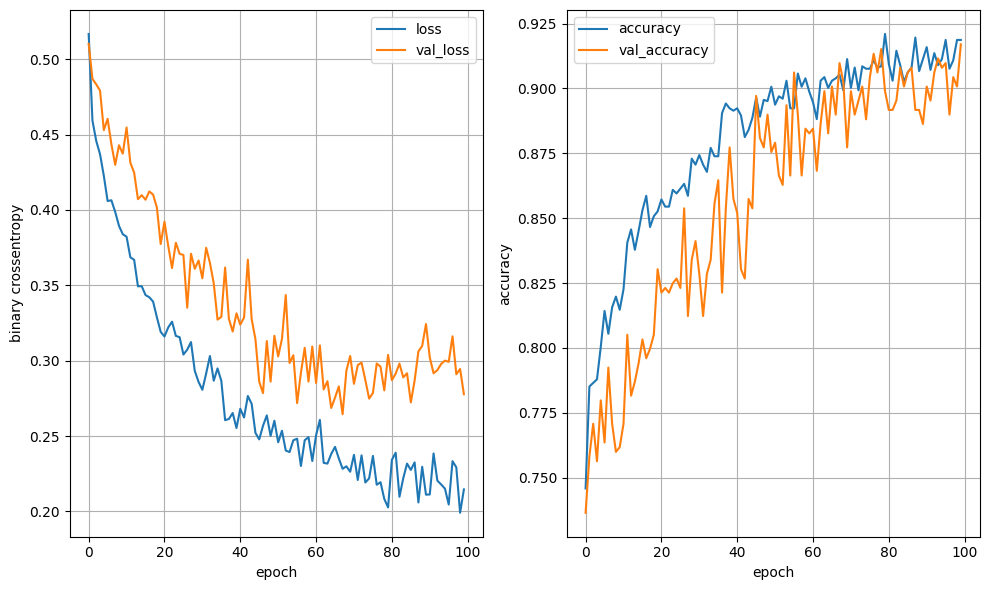

18/18 [==============================] - 0s 1ms/step - loss: 0.2777 - accuracy: 0.9170
32 nodes, dropout 0.2, lr 0.01, batch size 128


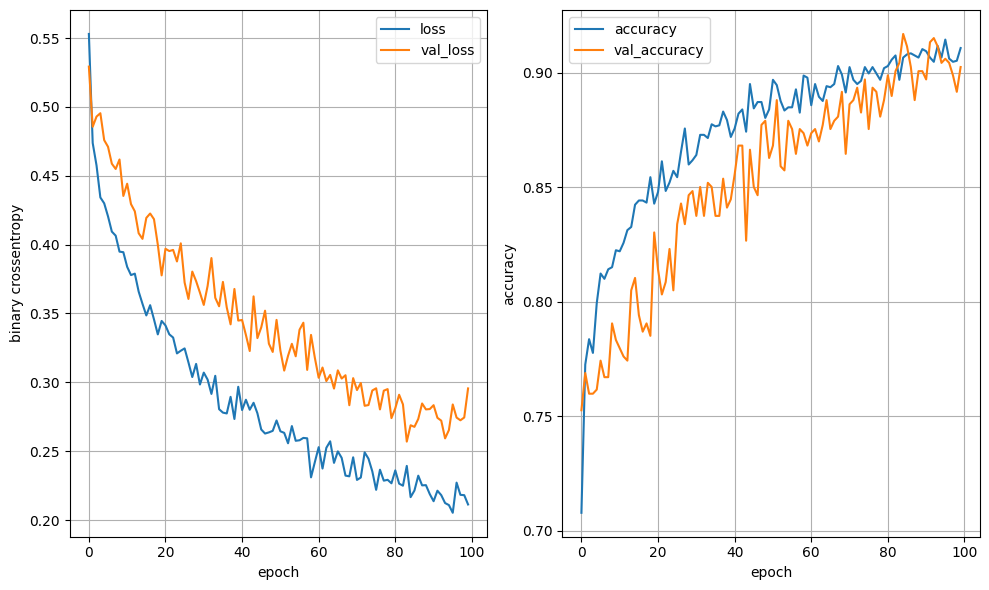

18/18 [==============================] - 0s 2ms/step - loss: 0.2956 - accuracy: 0.9025
32 nodes, dropout 0.2, lr 0.005, batch size 32


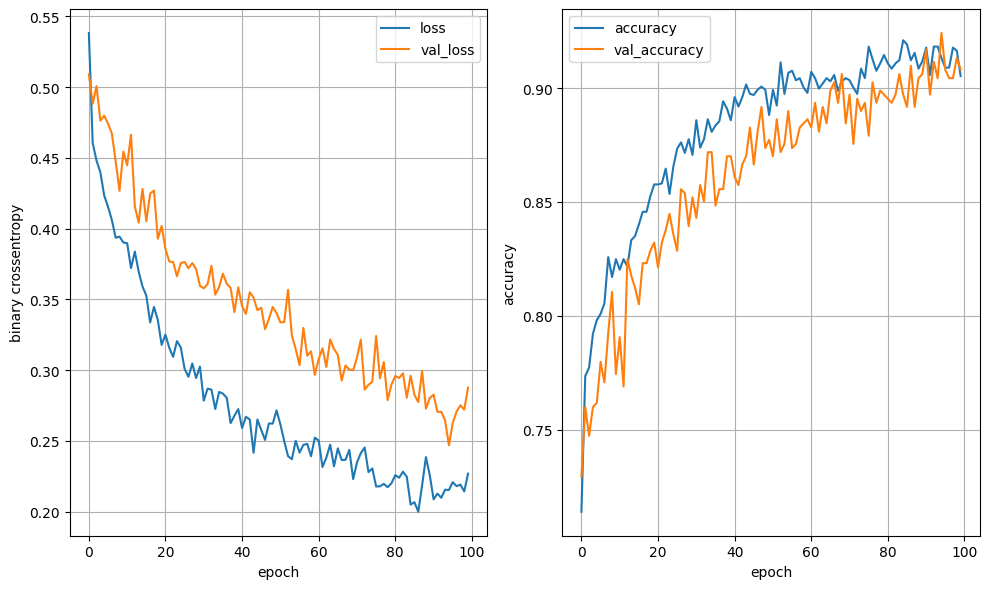

18/18 [==============================] - 0s 2ms/step - loss: 0.2875 - accuracy: 0.9079
32 nodes, dropout 0.2, lr 0.005, batch size 64


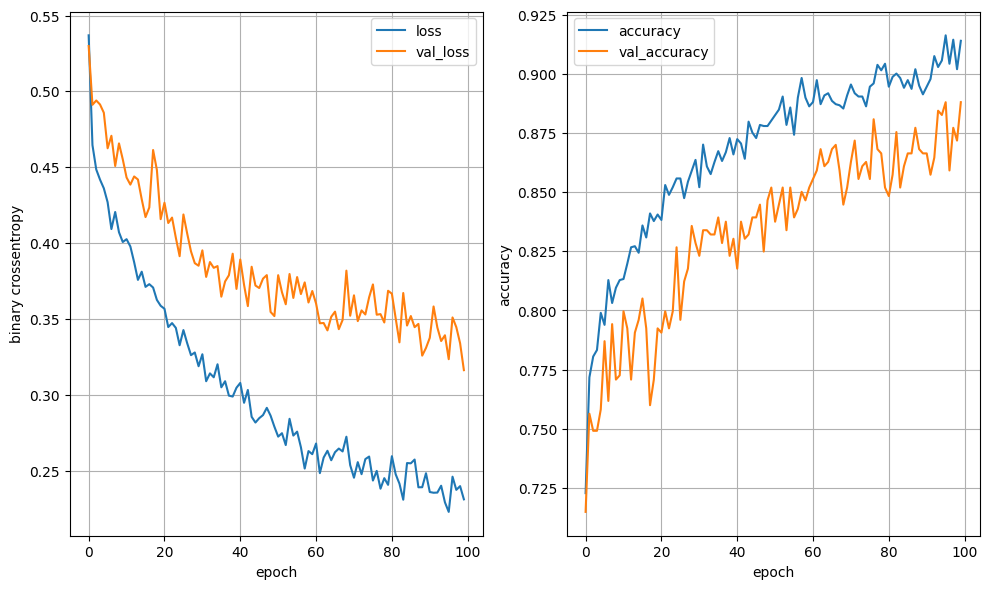

18/18 [==============================] - 0s 2ms/step - loss: 0.3163 - accuracy: 0.8881
32 nodes, dropout 0.2, lr 0.005, batch size 128


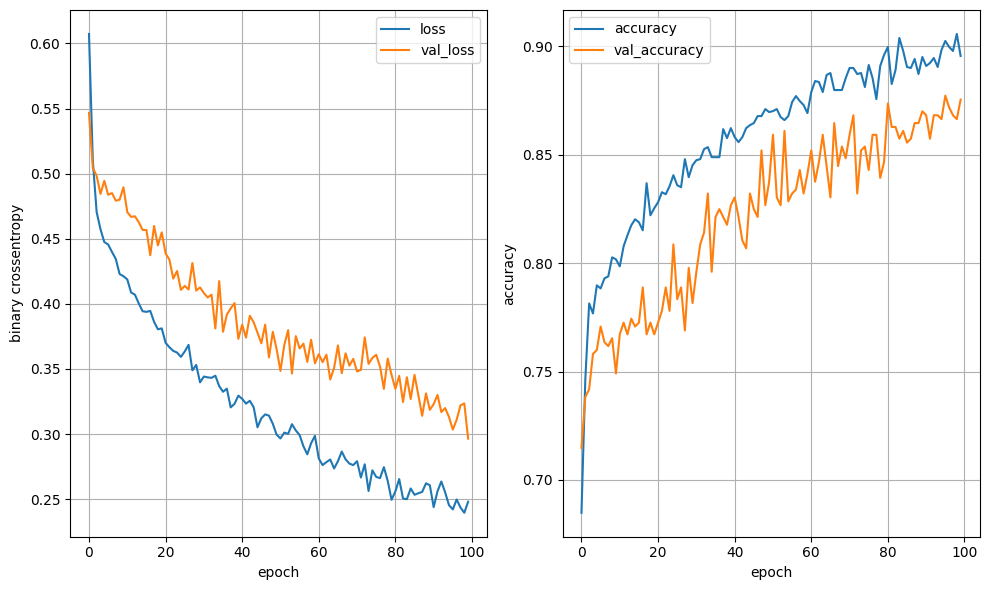

18/18 [==============================] - 0s 2ms/step - loss: 0.2965 - accuracy: 0.8755
32 nodes, dropout 0.2, lr 0.001, batch size 32


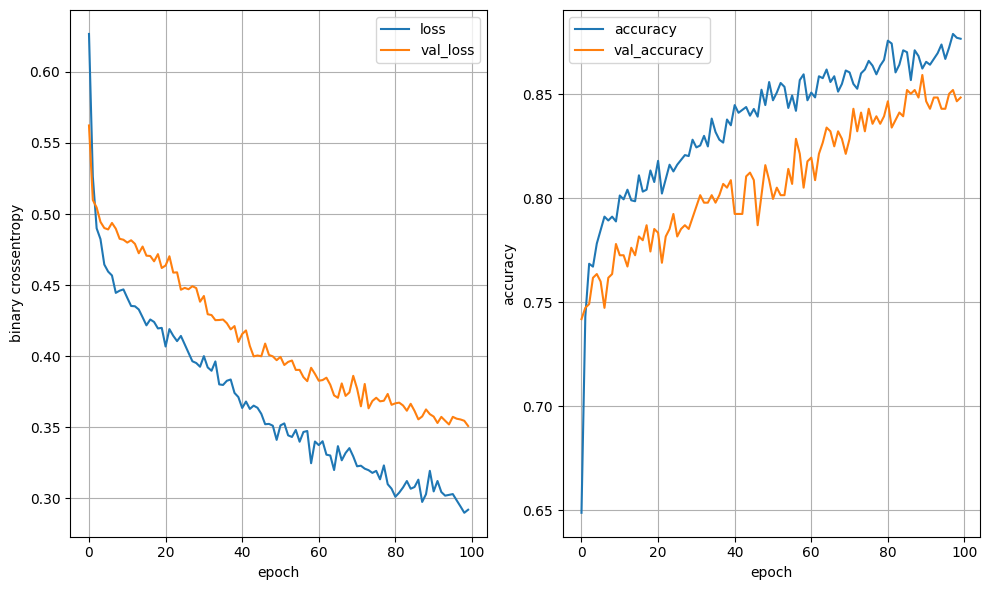

18/18 [==============================] - 0s 2ms/step - loss: 0.3508 - accuracy: 0.8484
32 nodes, dropout 0.2, lr 0.001, batch size 64


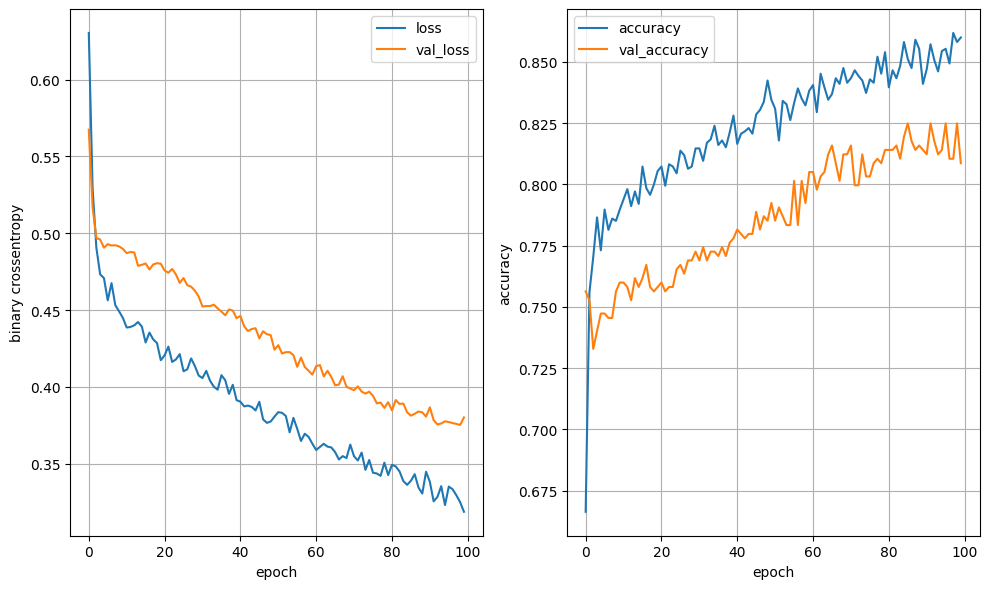

18/18 [==============================] - 0s 2ms/step - loss: 0.3801 - accuracy: 0.8087
32 nodes, dropout 0.2, lr 0.001, batch size 128


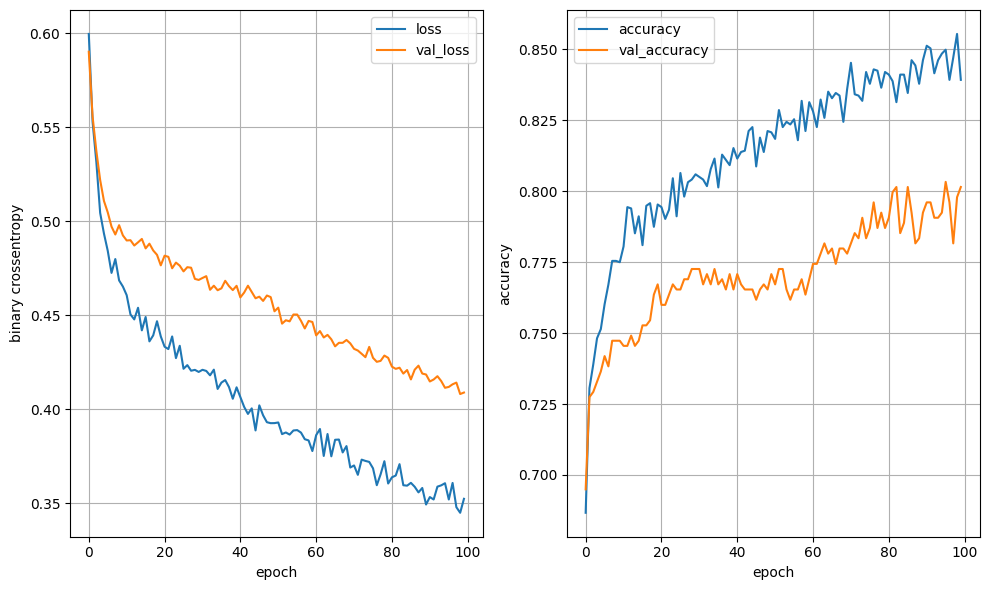

18/18 [==============================] - 0s 2ms/step - loss: 0.4089 - accuracy: 0.8014
64 nodes, dropout 0, lr 0.01, batch size 32


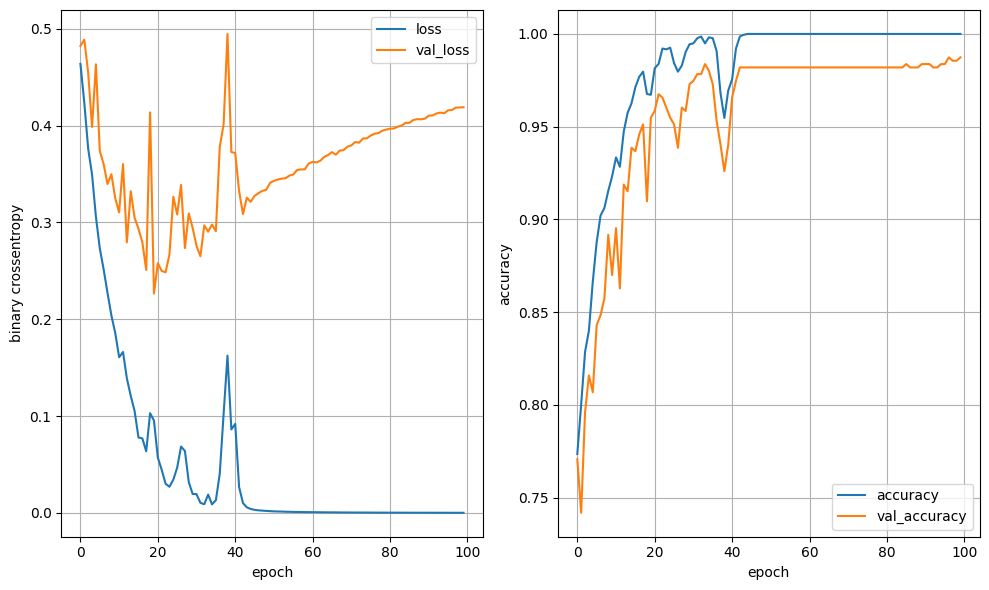

18/18 [==============================] - 0s 2ms/step - loss: 0.4189 - accuracy: 0.9874
64 nodes, dropout 0, lr 0.01, batch size 64


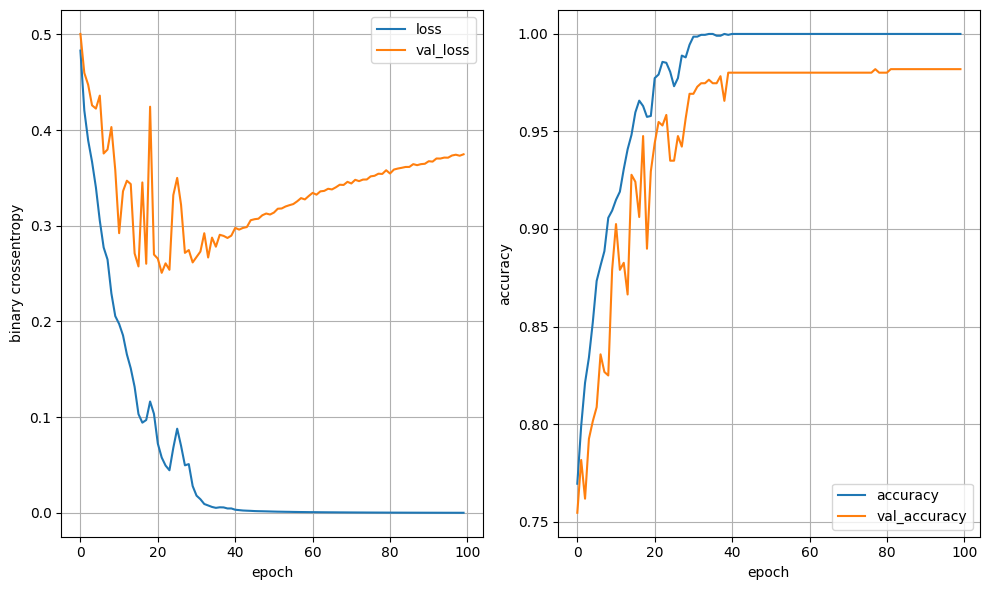

18/18 [==============================] - 0s 2ms/step - loss: 0.3746 - accuracy: 0.9819
64 nodes, dropout 0, lr 0.01, batch size 128


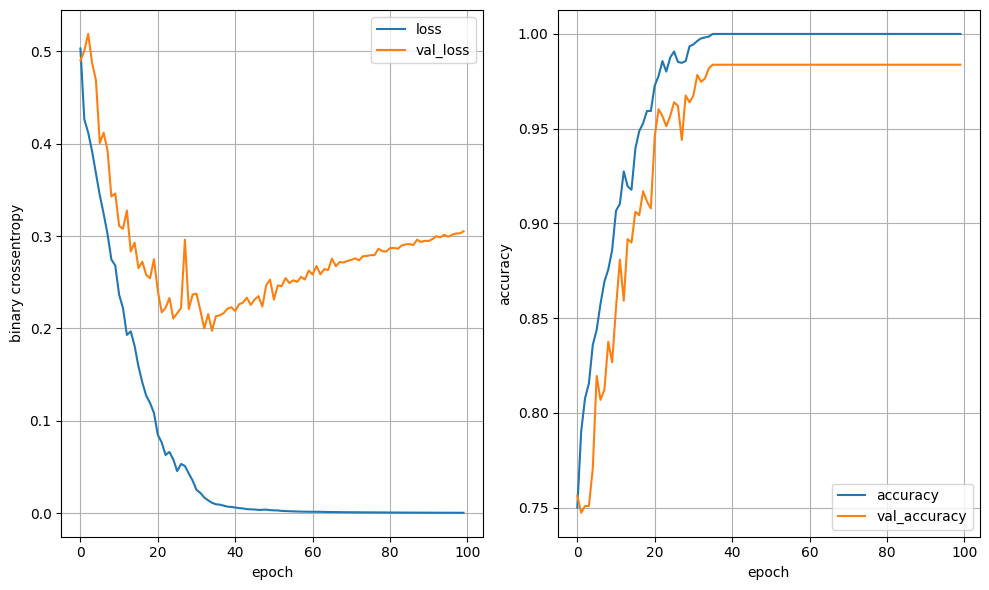

18/18 [==============================] - 0s 2ms/step - loss: 0.3051 - accuracy: 0.9838
64 nodes, dropout 0, lr 0.005, batch size 32


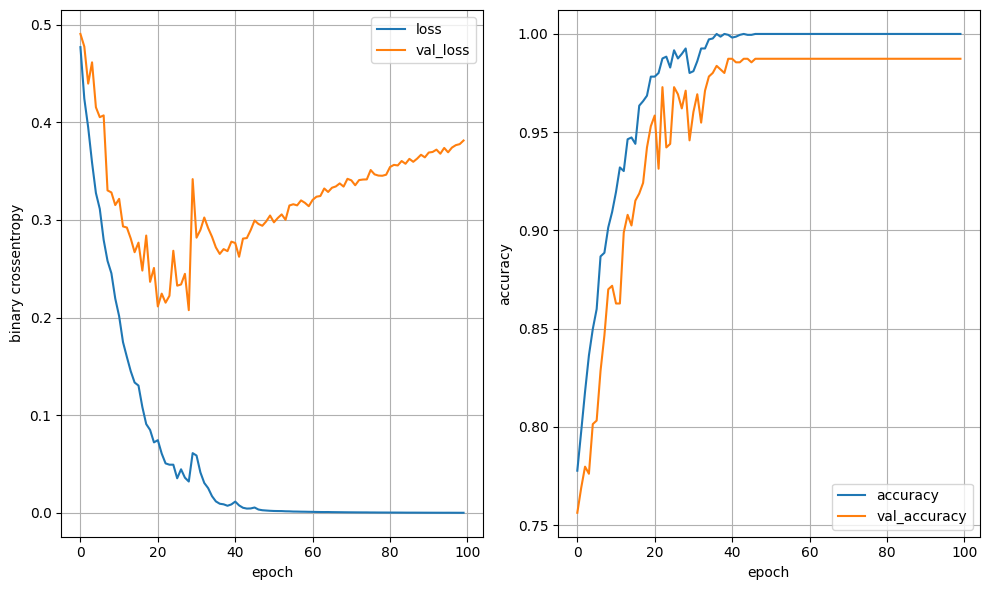

18/18 [==============================] - 0s 2ms/step - loss: 0.3813 - accuracy: 0.9874
64 nodes, dropout 0, lr 0.005, batch size 64


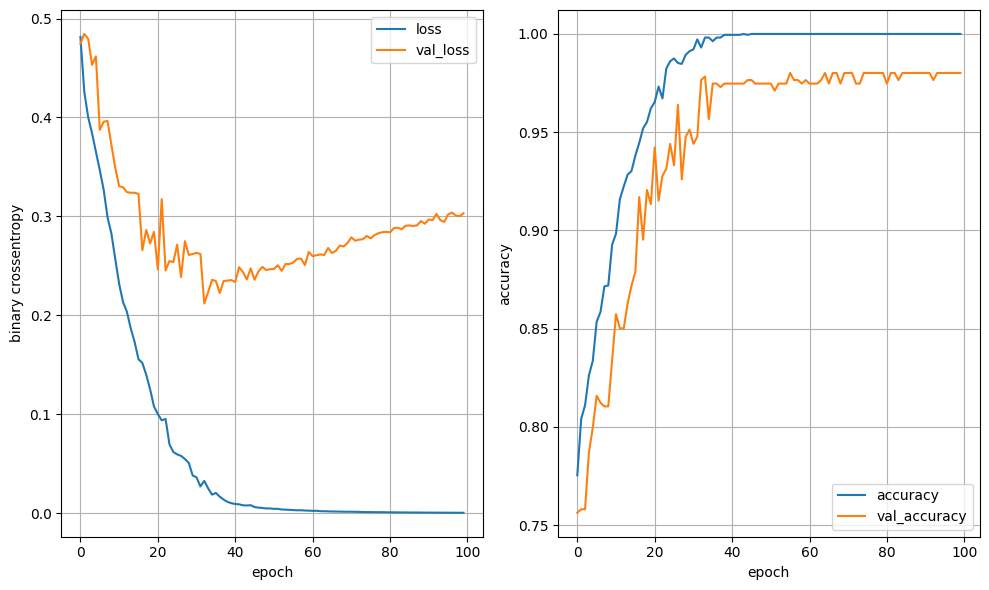

18/18 [==============================] - 0s 2ms/step - loss: 0.3032 - accuracy: 0.9801
64 nodes, dropout 0, lr 0.005, batch size 128


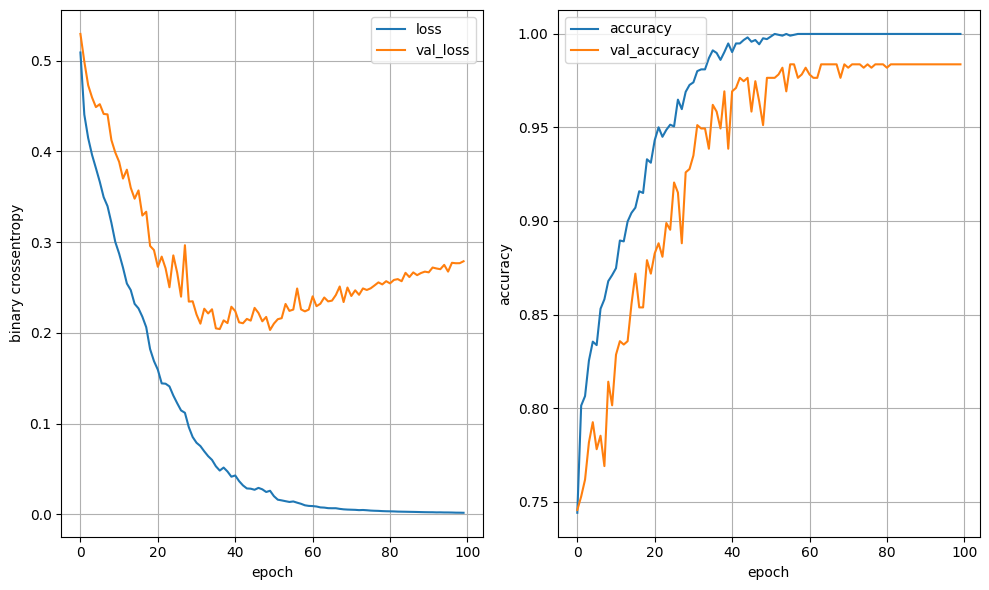

18/18 [==============================] - 0s 2ms/step - loss: 0.2789 - accuracy: 0.9838
64 nodes, dropout 0, lr 0.001, batch size 32


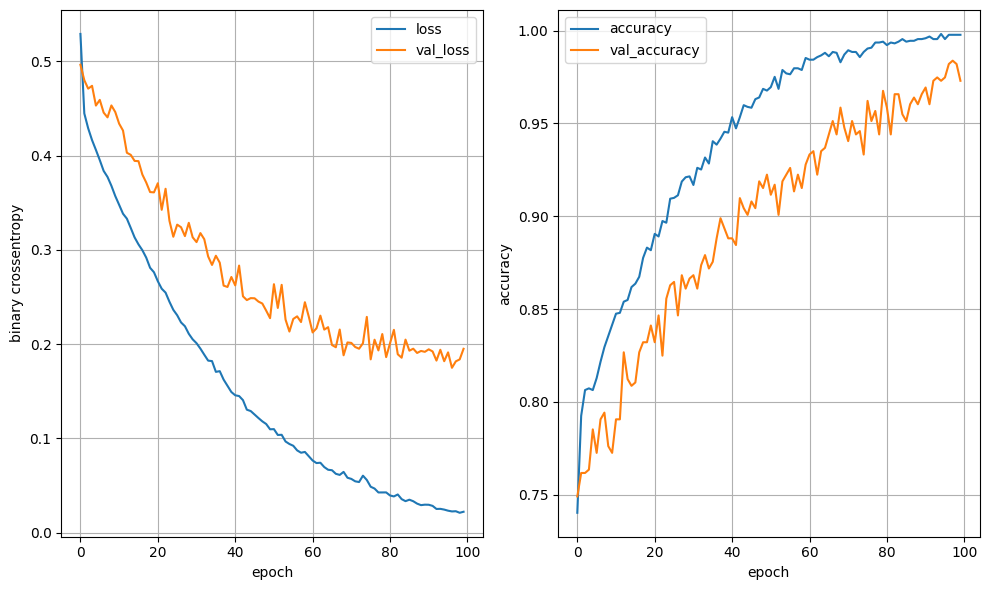

18/18 [==============================] - 0s 2ms/step - loss: 0.1951 - accuracy: 0.9729
64 nodes, dropout 0, lr 0.001, batch size 64


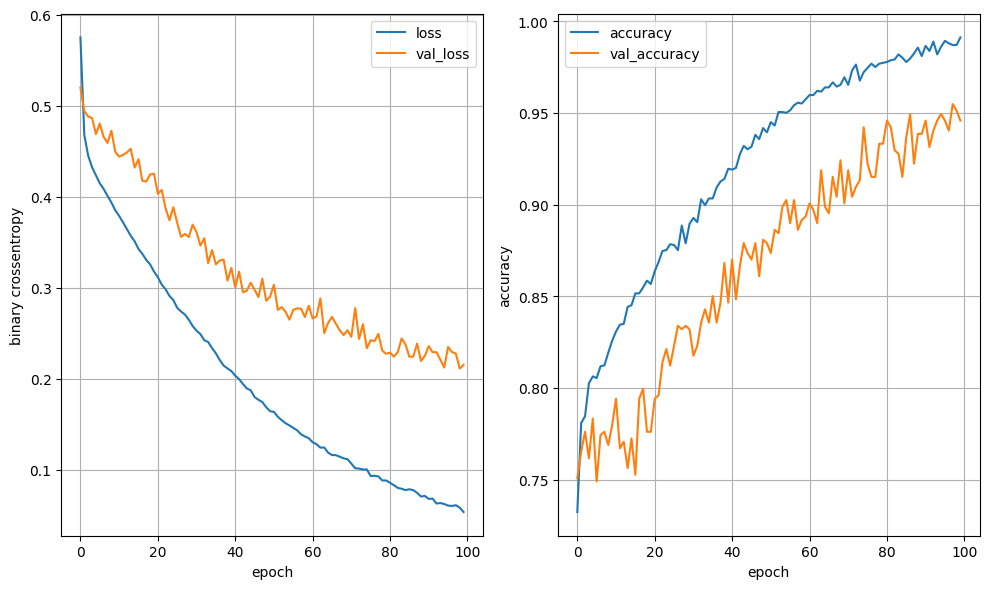

18/18 [==============================] - 0s 2ms/step - loss: 0.2152 - accuracy: 0.9458
64 nodes, dropout 0, lr 0.001, batch size 128


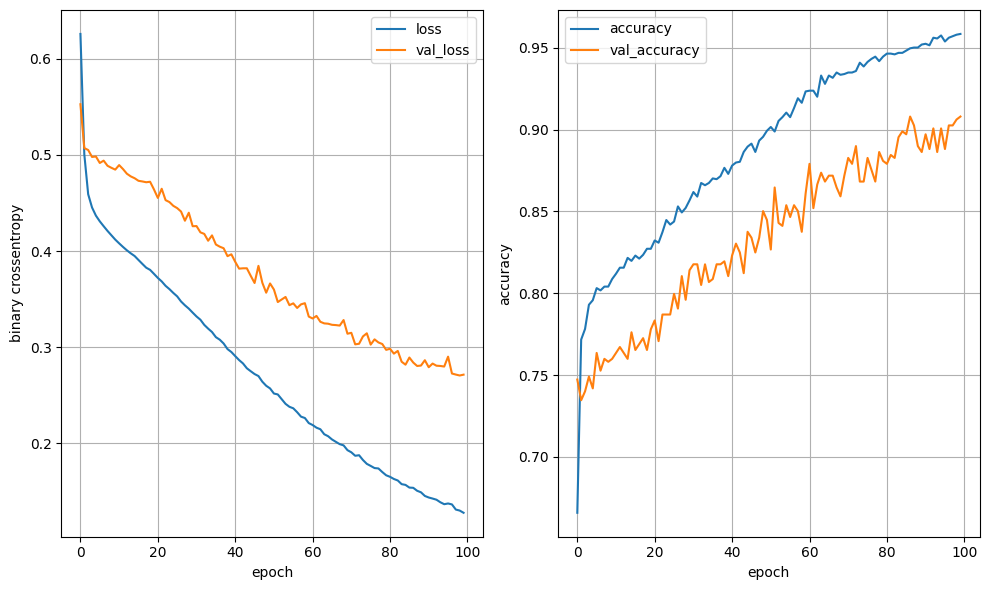

18/18 [==============================] - 0s 1ms/step - loss: 0.2715 - accuracy: 0.9079
64 nodes, dropout 0.2, lr 0.01, batch size 32


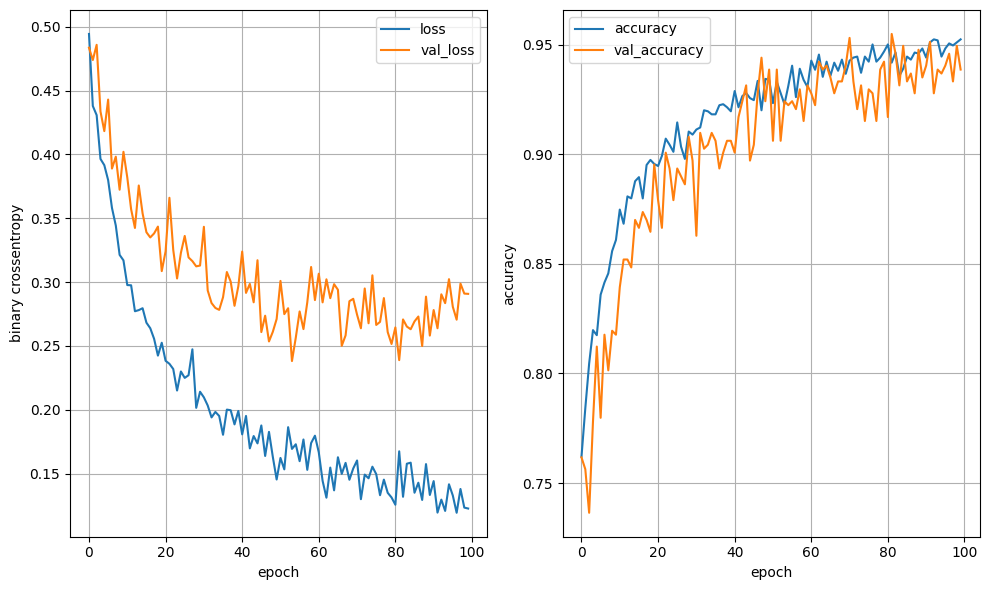

18/18 [==============================] - 0s 1ms/step - loss: 0.2908 - accuracy: 0.9386
64 nodes, dropout 0.2, lr 0.01, batch size 64


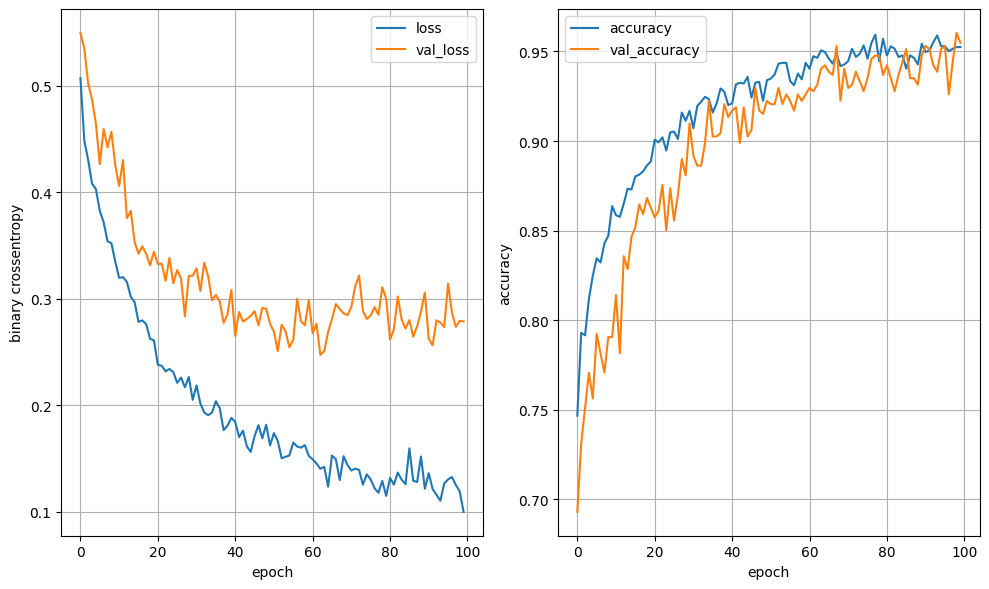

18/18 [==============================] - 0s 1ms/step - loss: 0.2787 - accuracy: 0.9549
64 nodes, dropout 0.2, lr 0.01, batch size 128


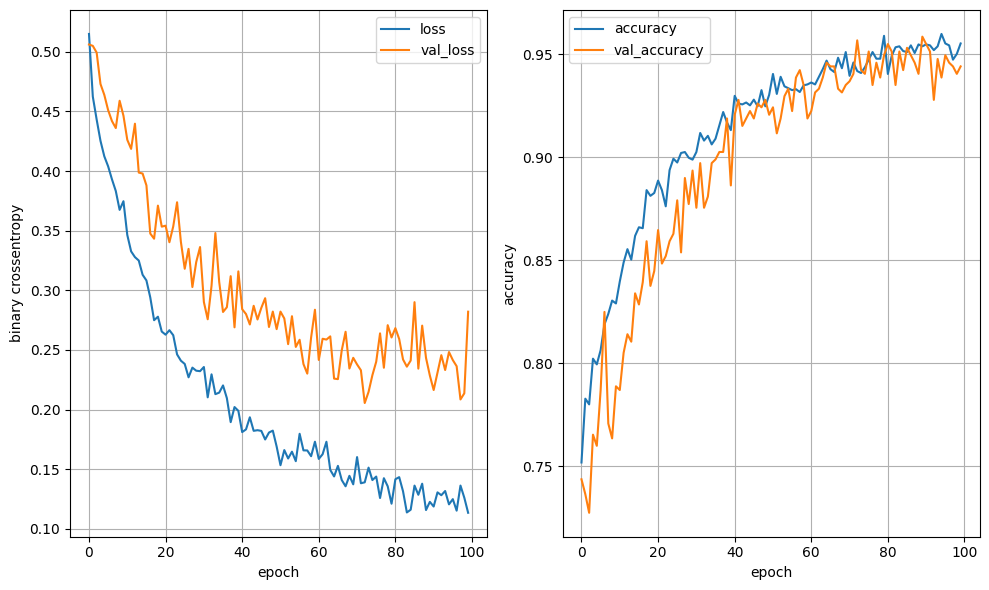

18/18 [==============================] - 0s 1ms/step - loss: 0.2820 - accuracy: 0.9440
64 nodes, dropout 0.2, lr 0.005, batch size 32


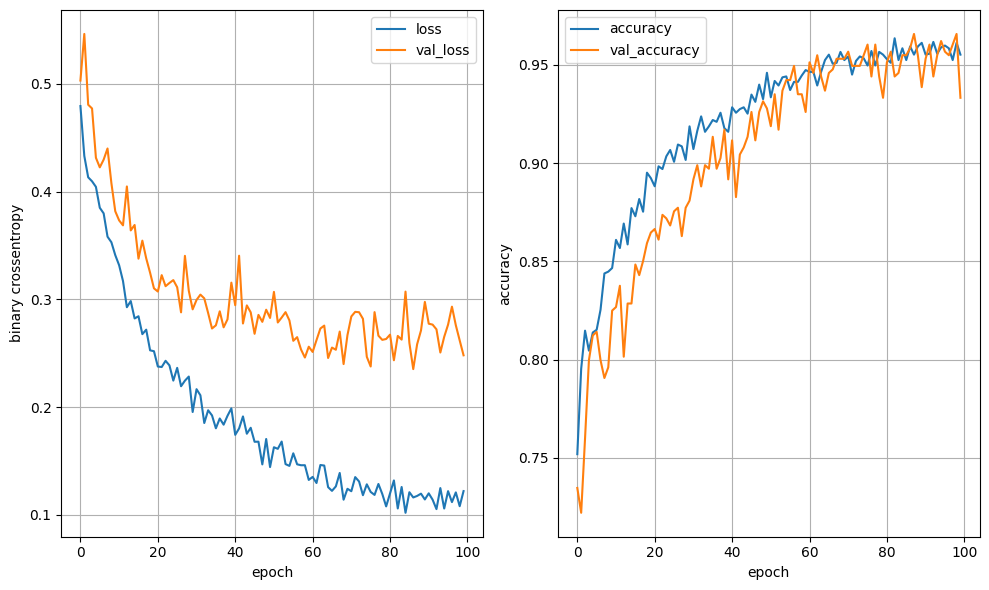

18/18 [==============================] - 0s 1ms/step - loss: 0.2482 - accuracy: 0.9332
64 nodes, dropout 0.2, lr 0.005, batch size 64


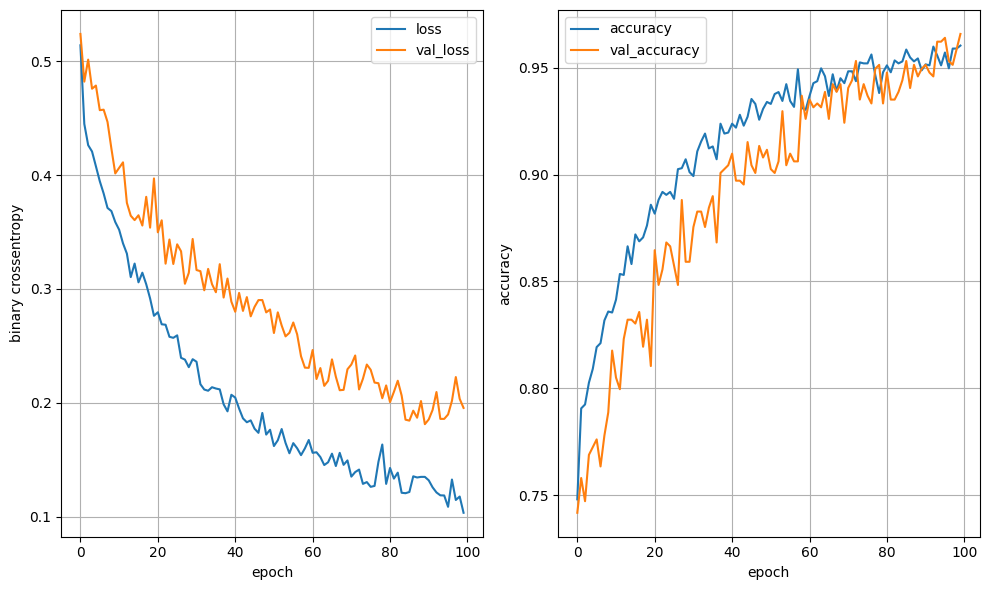

18/18 [==============================] - 0s 1ms/step - loss: 0.1955 - accuracy: 0.9657
64 nodes, dropout 0.2, lr 0.005, batch size 128


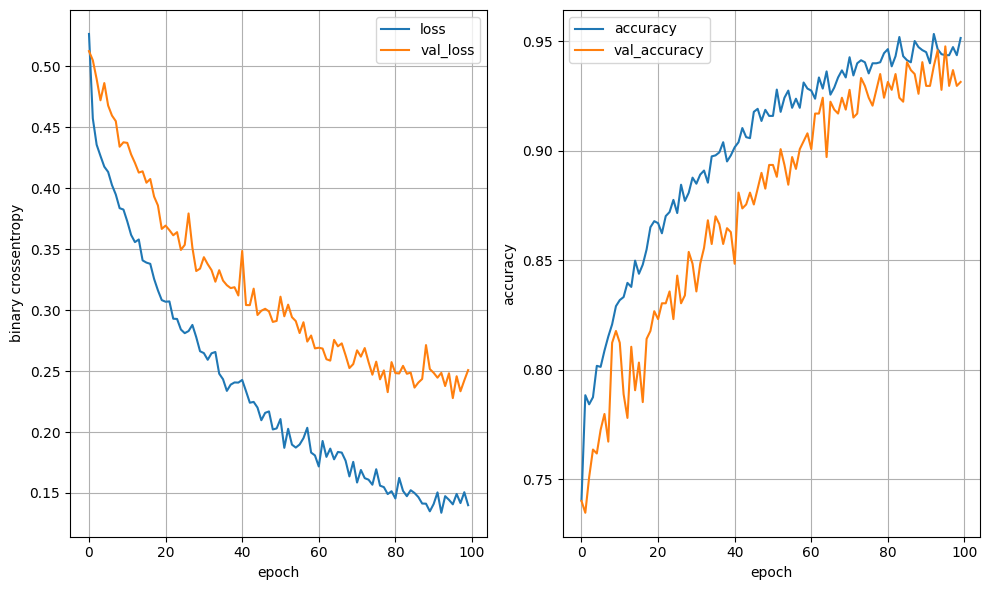

18/18 [==============================] - 0s 1ms/step - loss: 0.2508 - accuracy: 0.9314
64 nodes, dropout 0.2, lr 0.001, batch size 32


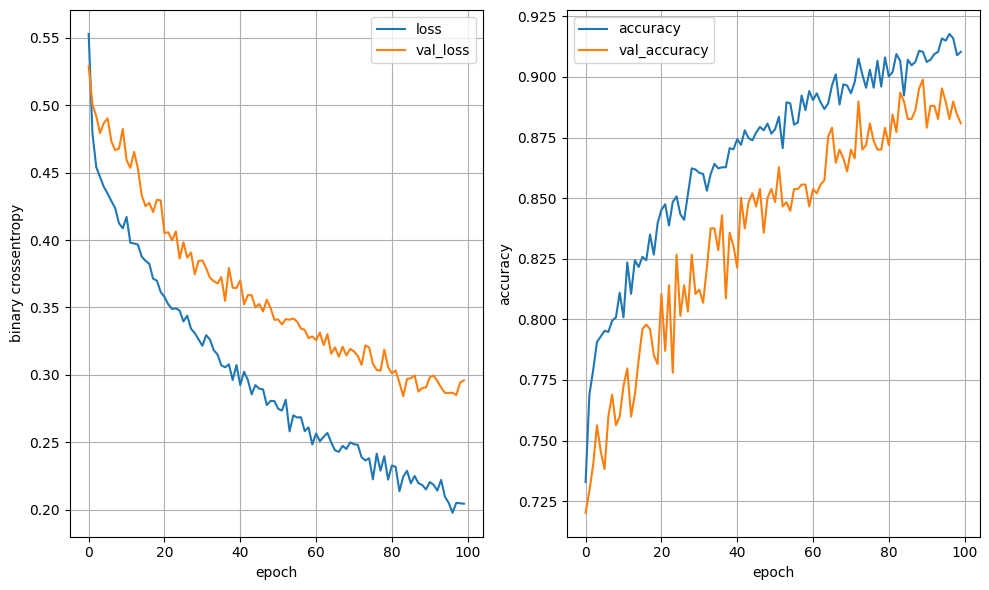

18/18 [==============================] - 0s 1ms/step - loss: 0.2959 - accuracy: 0.8809
64 nodes, dropout 0.2, lr 0.001, batch size 64


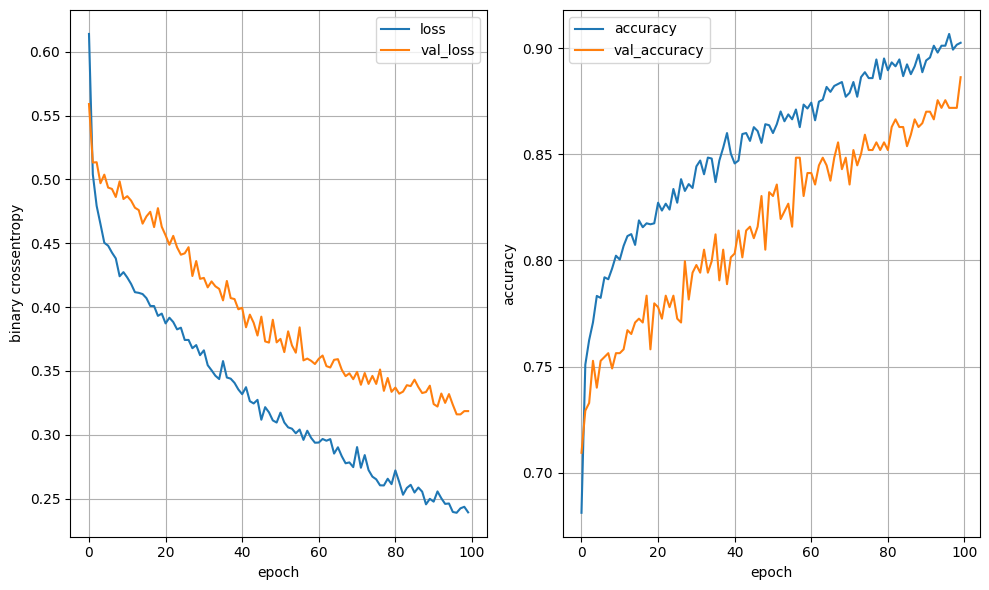

18/18 [==============================] - 0s 1ms/step - loss: 0.3186 - accuracy: 0.8863
64 nodes, dropout 0.2, lr 0.001, batch size 128


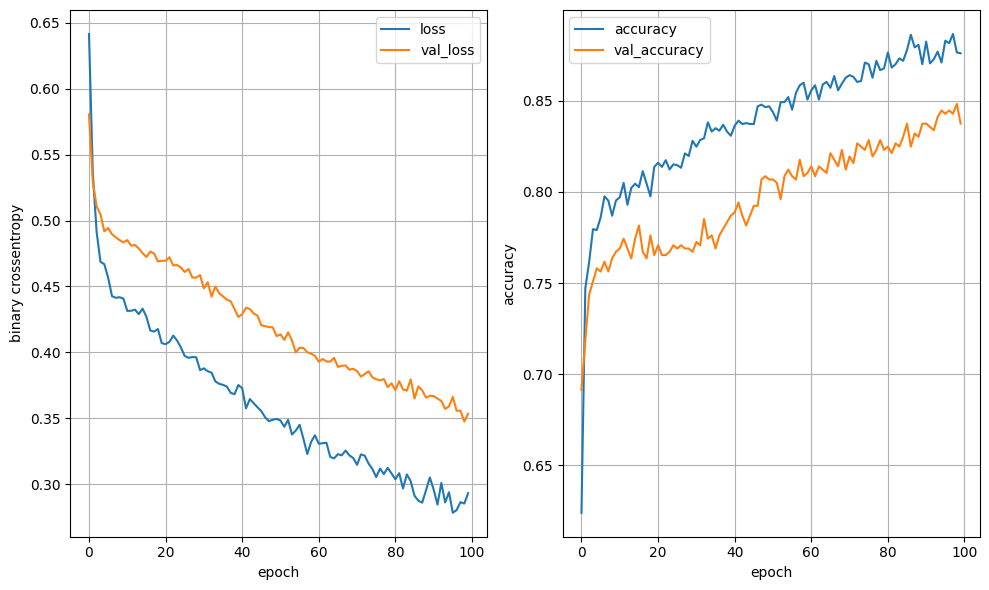

18/18 [==============================] - 0s 2ms/step - loss: 0.3535 - accuracy: 0.8375
128 nodes, dropout 0, lr 0.01, batch size 32


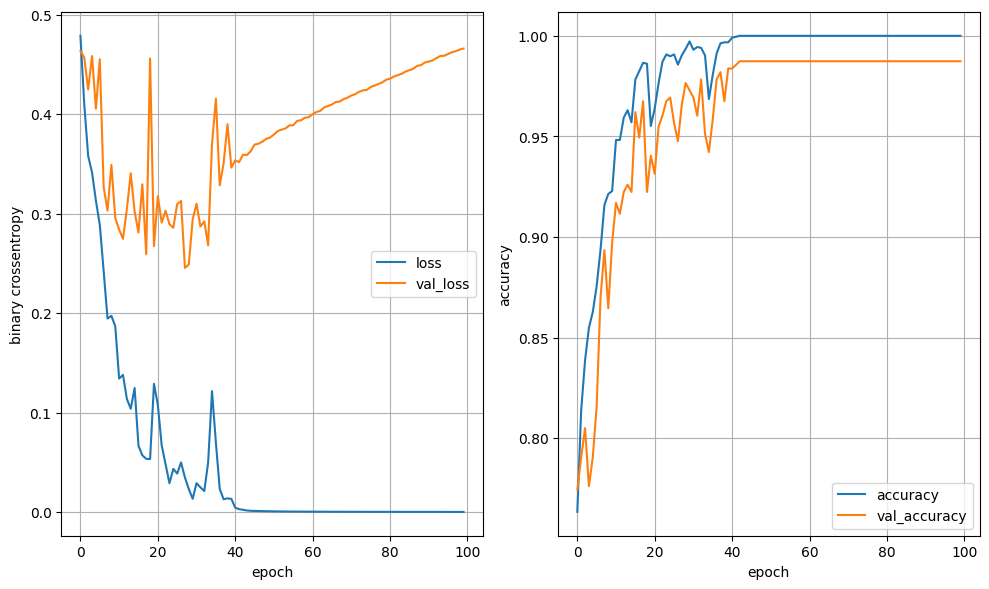

18/18 [==============================] - 0s 3ms/step - loss: 0.4661 - accuracy: 0.9874
128 nodes, dropout 0, lr 0.01, batch size 64


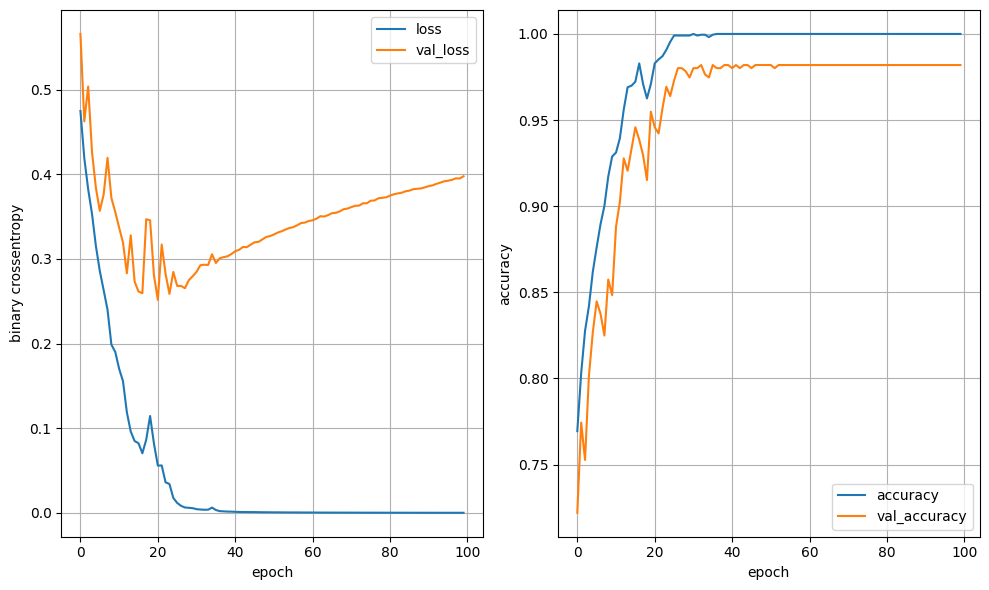

18/18 [==============================] - 0s 2ms/step - loss: 0.3975 - accuracy: 0.9819
128 nodes, dropout 0, lr 0.01, batch size 128


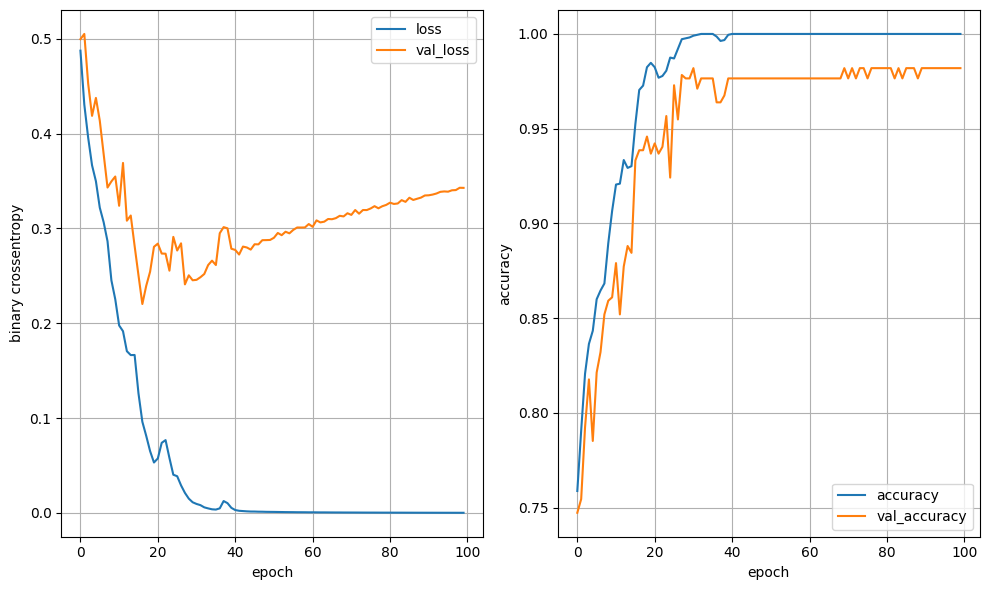

18/18 [==============================] - 0s 2ms/step - loss: 0.3428 - accuracy: 0.9819
128 nodes, dropout 0, lr 0.005, batch size 32


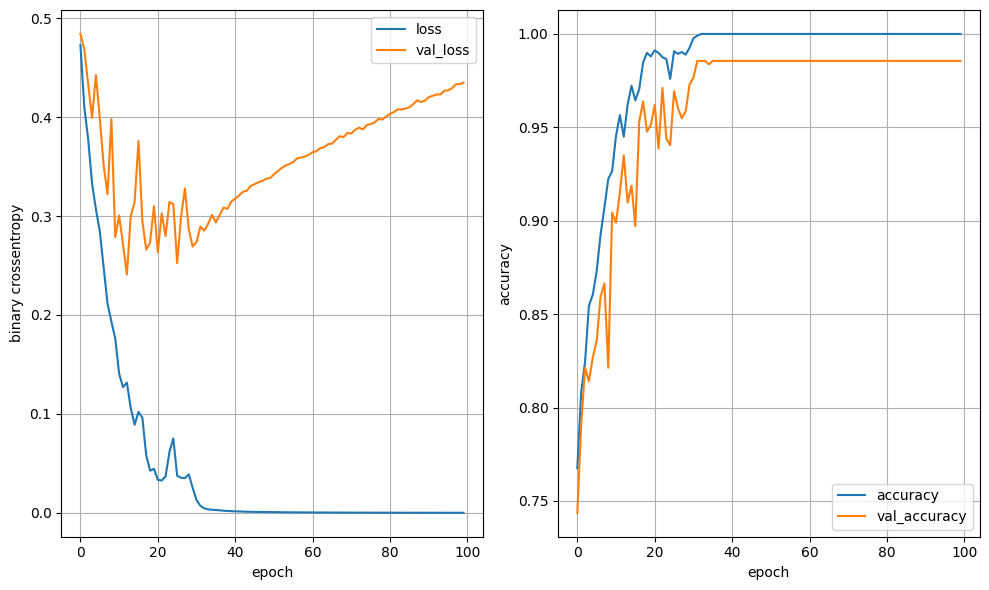

18/18 [==============================] - 0s 2ms/step - loss: 0.4349 - accuracy: 0.9856
128 nodes, dropout 0, lr 0.005, batch size 64


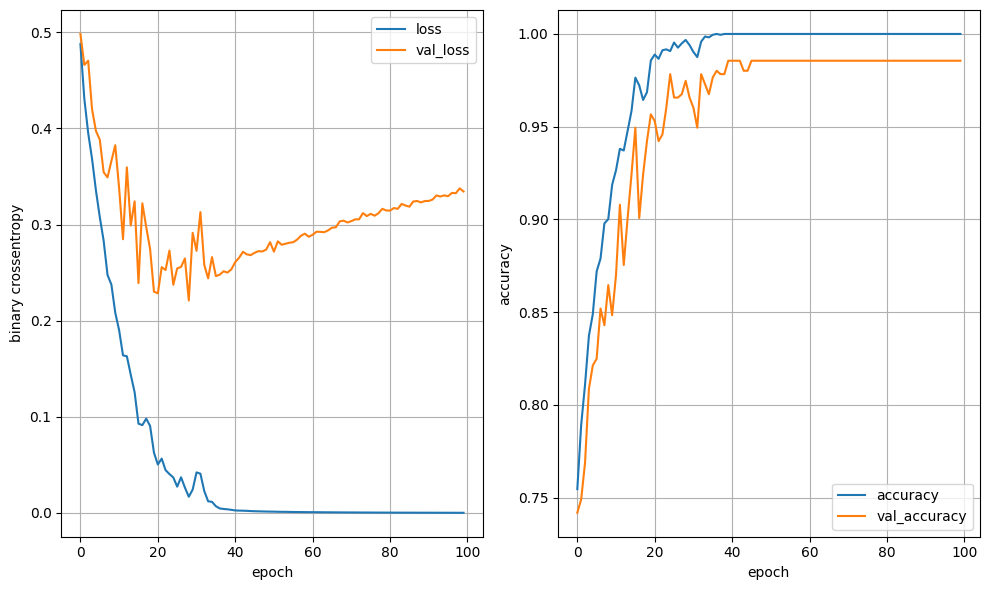

18/18 [==============================] - 0s 1ms/step - loss: 0.3344 - accuracy: 0.9856
128 nodes, dropout 0, lr 0.005, batch size 128


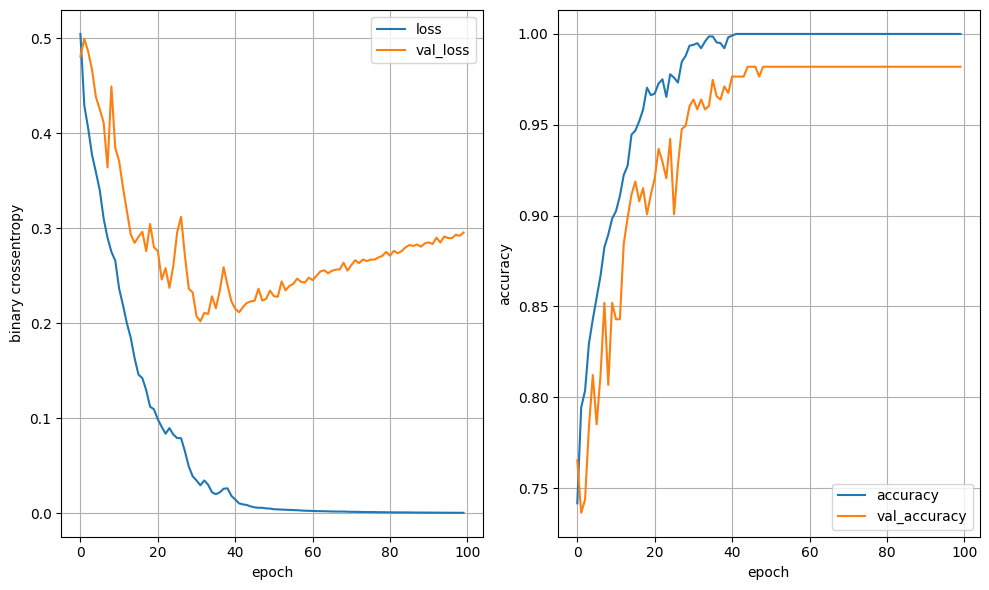

18/18 [==============================] - 0s 8ms/step - loss: 0.2955 - accuracy: 0.9819
128 nodes, dropout 0, lr 0.001, batch size 32


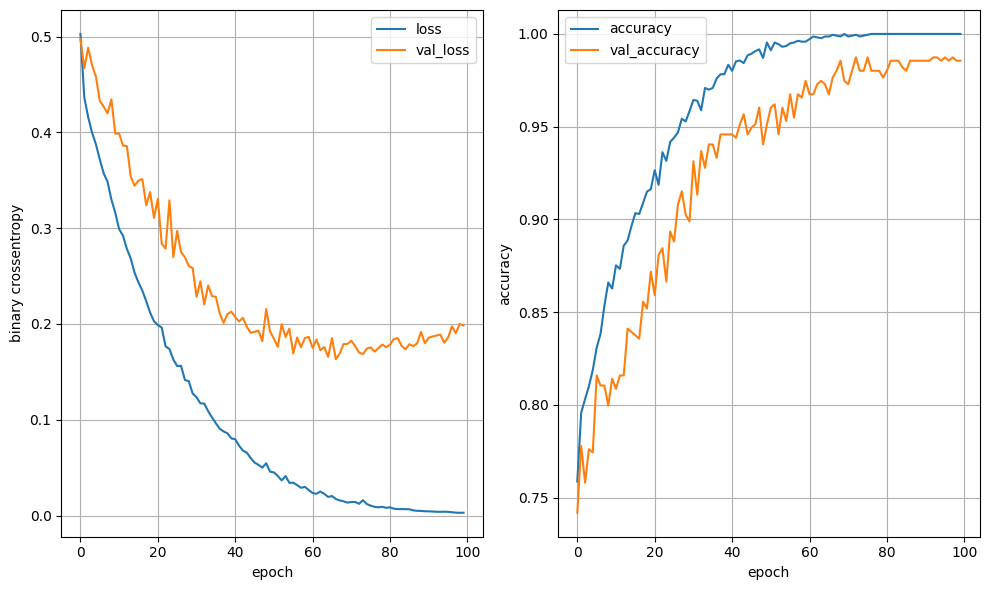

18/18 [==============================] - 0s 2ms/step - loss: 0.1985 - accuracy: 0.9856
128 nodes, dropout 0, lr 0.001, batch size 64


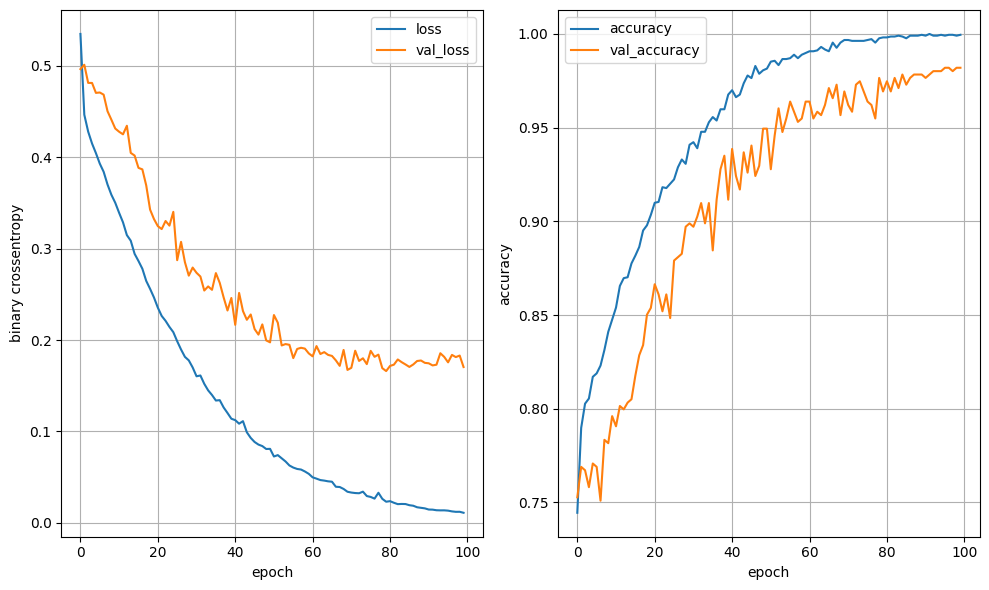

18/18 [==============================] - 0s 2ms/step - loss: 0.1704 - accuracy: 0.9819
128 nodes, dropout 0, lr 0.001, batch size 128


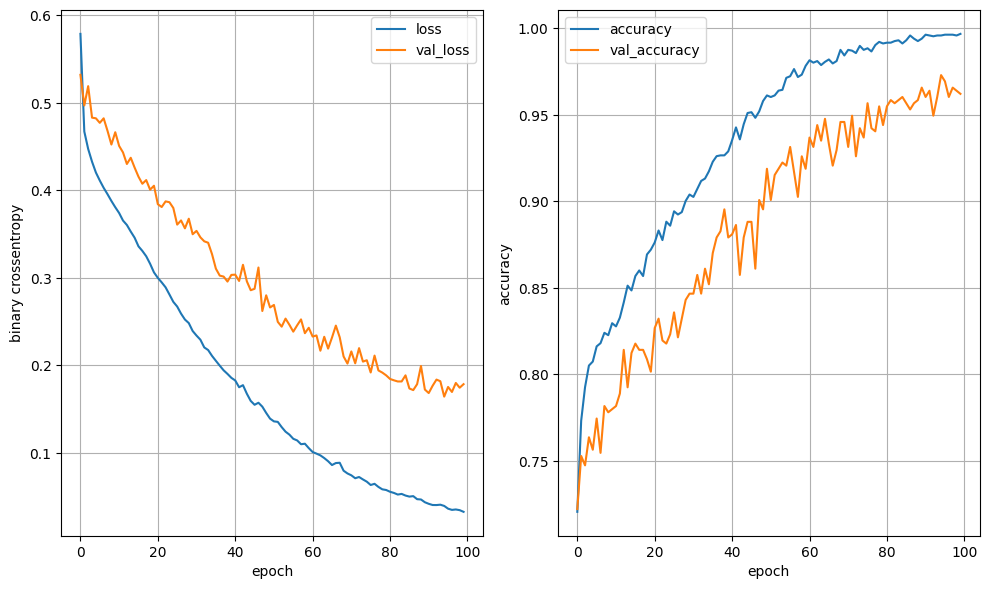

18/18 [==============================] - 0s 9ms/step - loss: 0.1784 - accuracy: 0.9621
128 nodes, dropout 0.2, lr 0.01, batch size 32


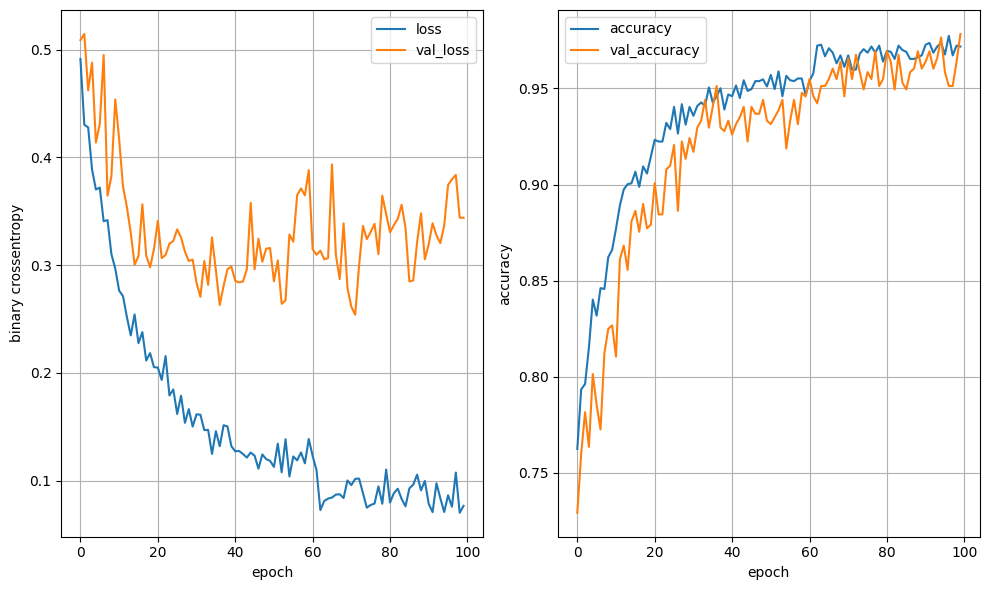

18/18 [==============================] - 0s 2ms/step - loss: 0.3439 - accuracy: 0.9783
128 nodes, dropout 0.2, lr 0.01, batch size 64


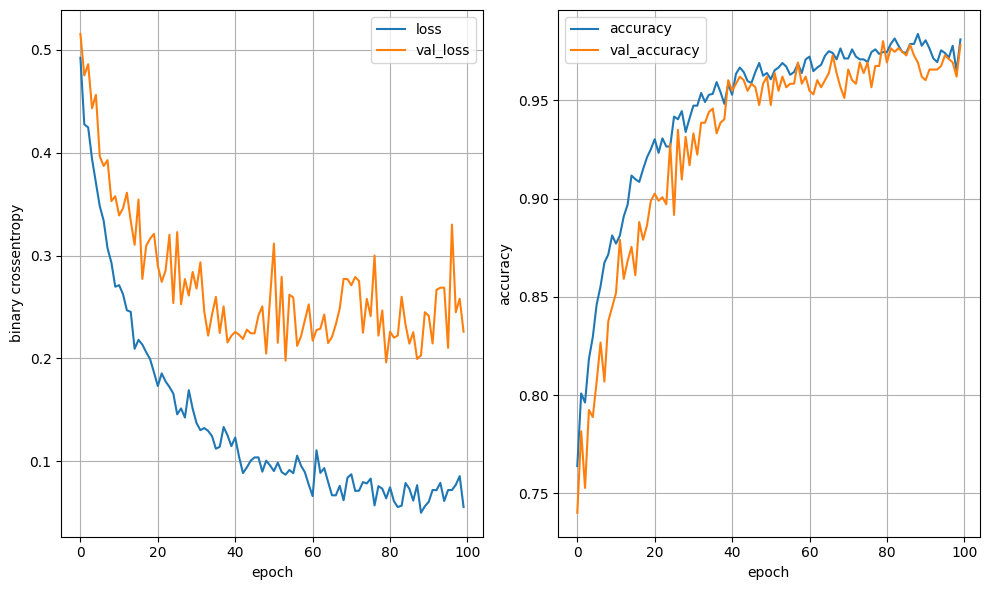

18/18 [==============================] - 0s 2ms/step - loss: 0.2260 - accuracy: 0.9783
128 nodes, dropout 0.2, lr 0.01, batch size 128


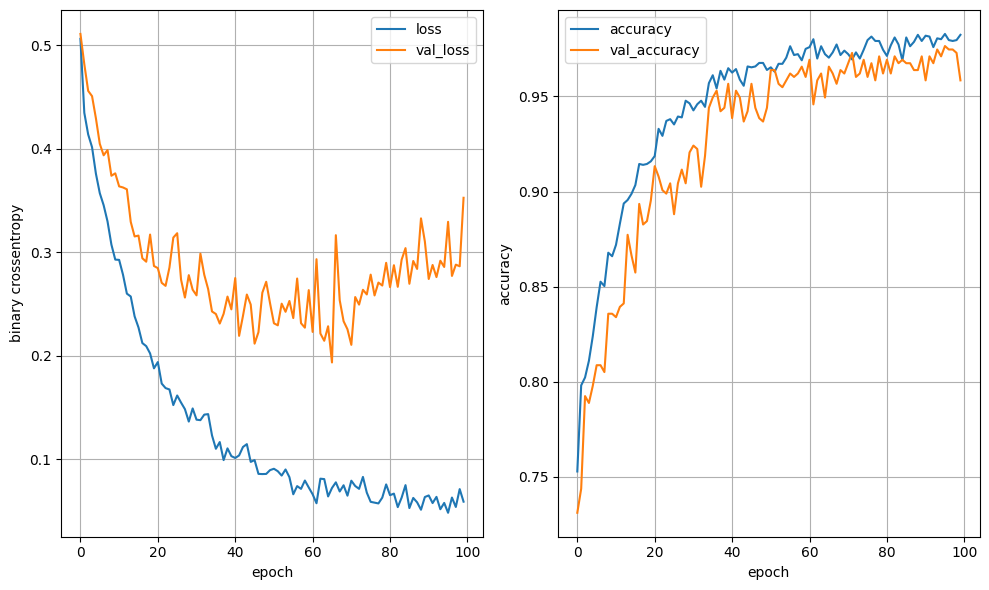

18/18 [==============================] - 0s 2ms/step - loss: 0.3526 - accuracy: 0.9585
128 nodes, dropout 0.2, lr 0.005, batch size 32


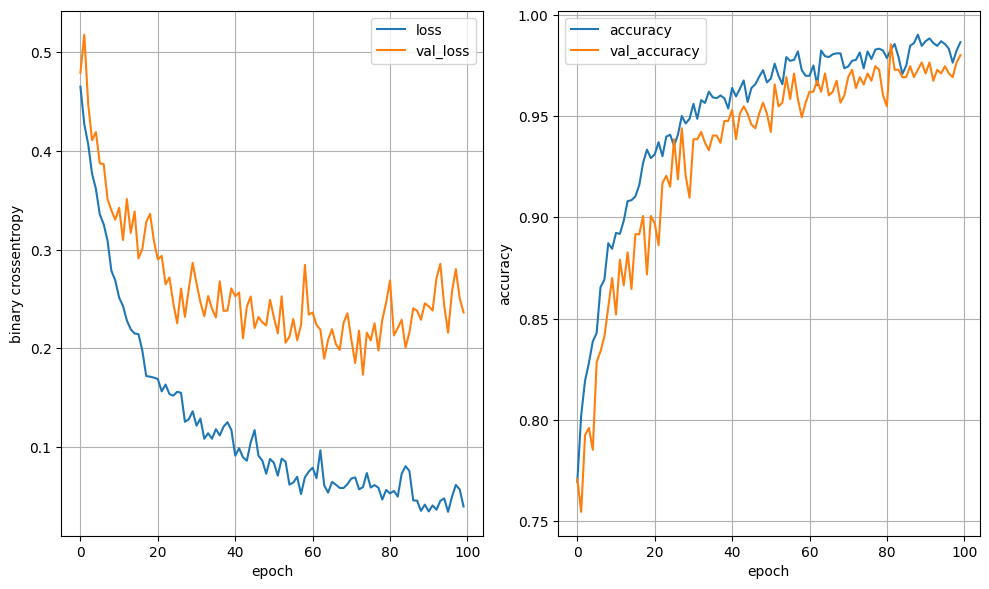

18/18 [==============================] - 0s 2ms/step - loss: 0.2364 - accuracy: 0.9801
128 nodes, dropout 0.2, lr 0.005, batch size 64


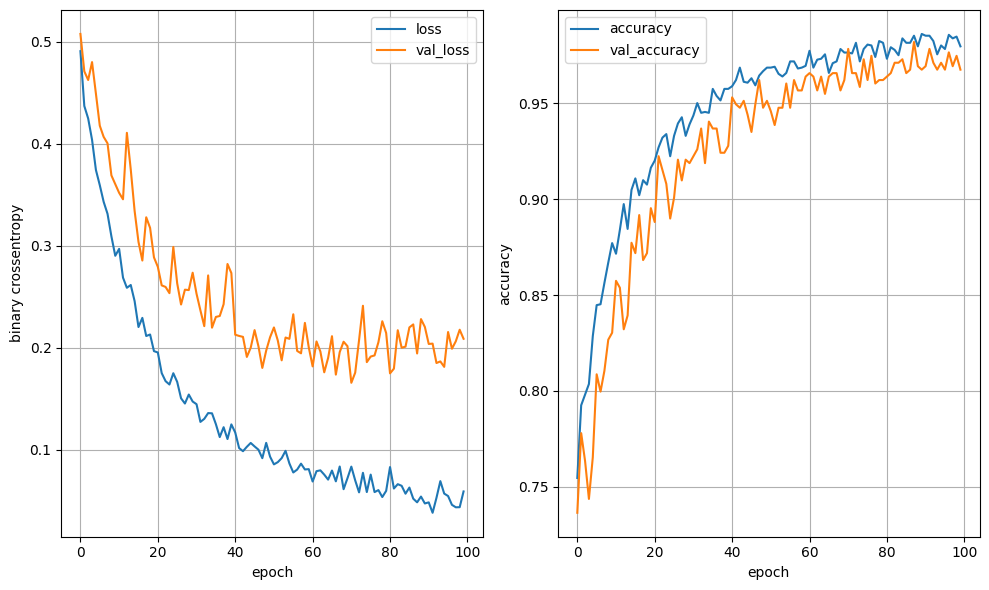

18/18 [==============================] - 0s 2ms/step - loss: 0.2086 - accuracy: 0.9675
128 nodes, dropout 0.2, lr 0.005, batch size 128


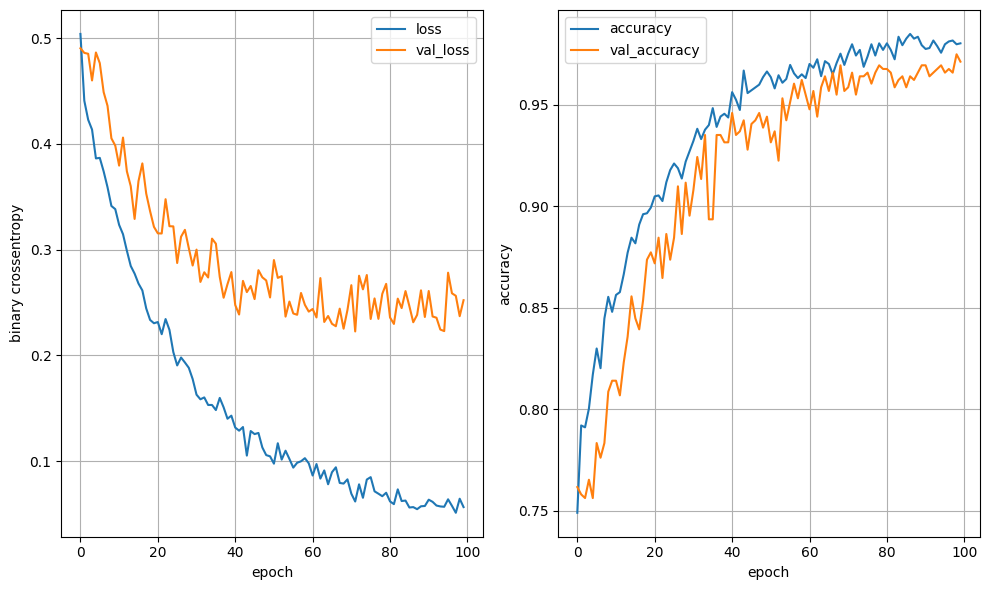

18/18 [==============================] - 0s 2ms/step - loss: 0.2522 - accuracy: 0.9711
128 nodes, dropout 0.2, lr 0.001, batch size 32


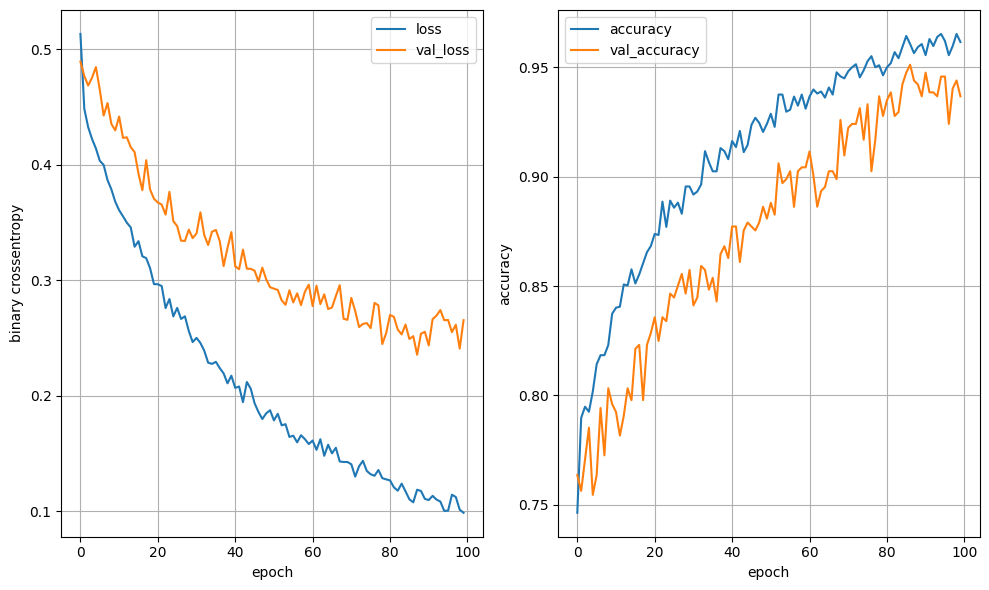

18/18 [==============================] - 0s 10ms/step - loss: 0.2654 - accuracy: 0.9368
128 nodes, dropout 0.2, lr 0.001, batch size 64


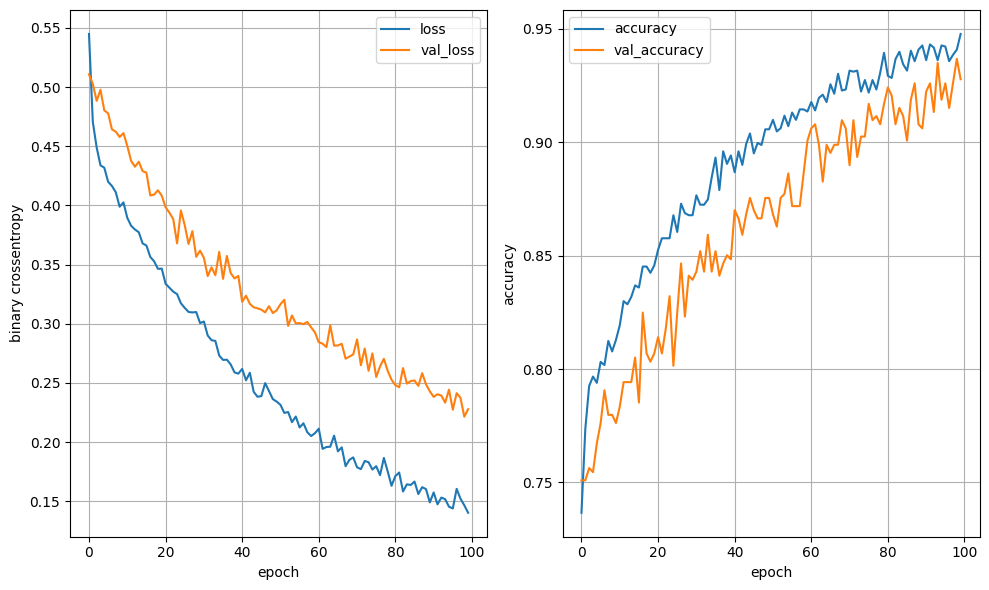

18/18 [==============================] - 0s 2ms/step - loss: 0.2279 - accuracy: 0.9278
128 nodes, dropout 0.2, lr 0.001, batch size 128


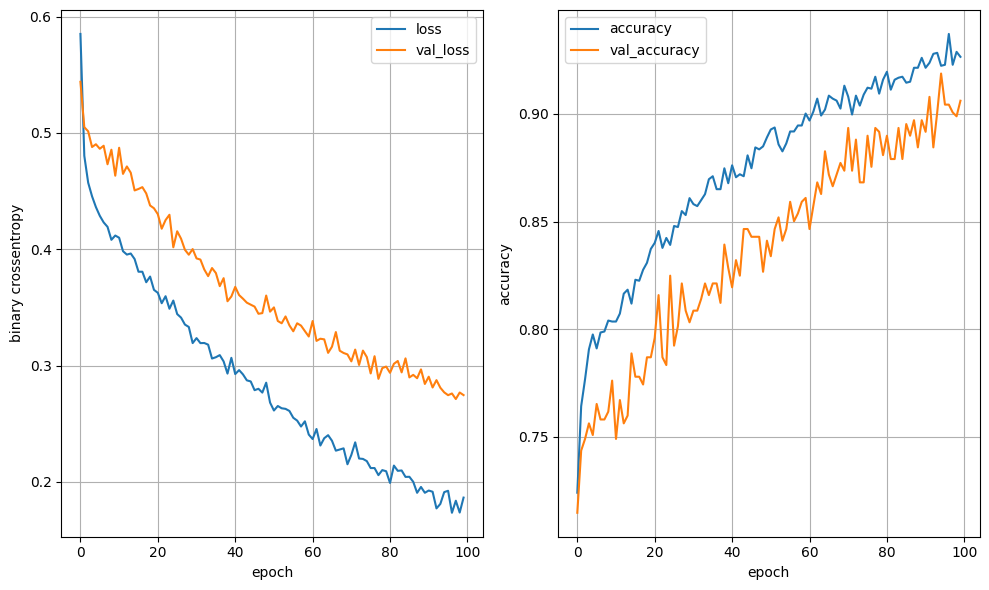

18/18 [==============================] - 0s 2ms/step - loss: 0.2746 - accuracy: 0.9061


In [27]:
least_val_loss = float("inf")
least_loss_model = None
epochs = 100

for num_nodes in [16, 32, 64, 128]:
    for dropout_prob in [0, 0.2]:
        for lr in [0.01, 0.005, 0.001]:
            for batch_size in [32, 64, 128]:
                print(f"{num_nodes} nodes, dropout {dropout_prob}, lr {lr}, batch size {batch_size}")
                model, history = train_model(X_train, y_train, num_nodes, dropout_prob, lr, batch_size, epochs)
                plot(history)
                val_loss = model.evaluate(X_valid, y_valid)[0]
                if val_loss < least_val_loss:
                    least_val_loss = val_loss
                    least_loss_model = model

In [30]:
y_pred = least_loss_model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int).reshape(-1,)
y_pred

18/18 [==============================] - 0s 1ms/step


array([0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1,
       1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0,

In [32]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       381
           1       0.93      0.96      0.94       173

    accuracy                           0.96       554
   macro avg       0.95      0.96      0.96       554
weighted avg       0.96      0.96      0.96       554

